测试矩阵 ADD32
4960


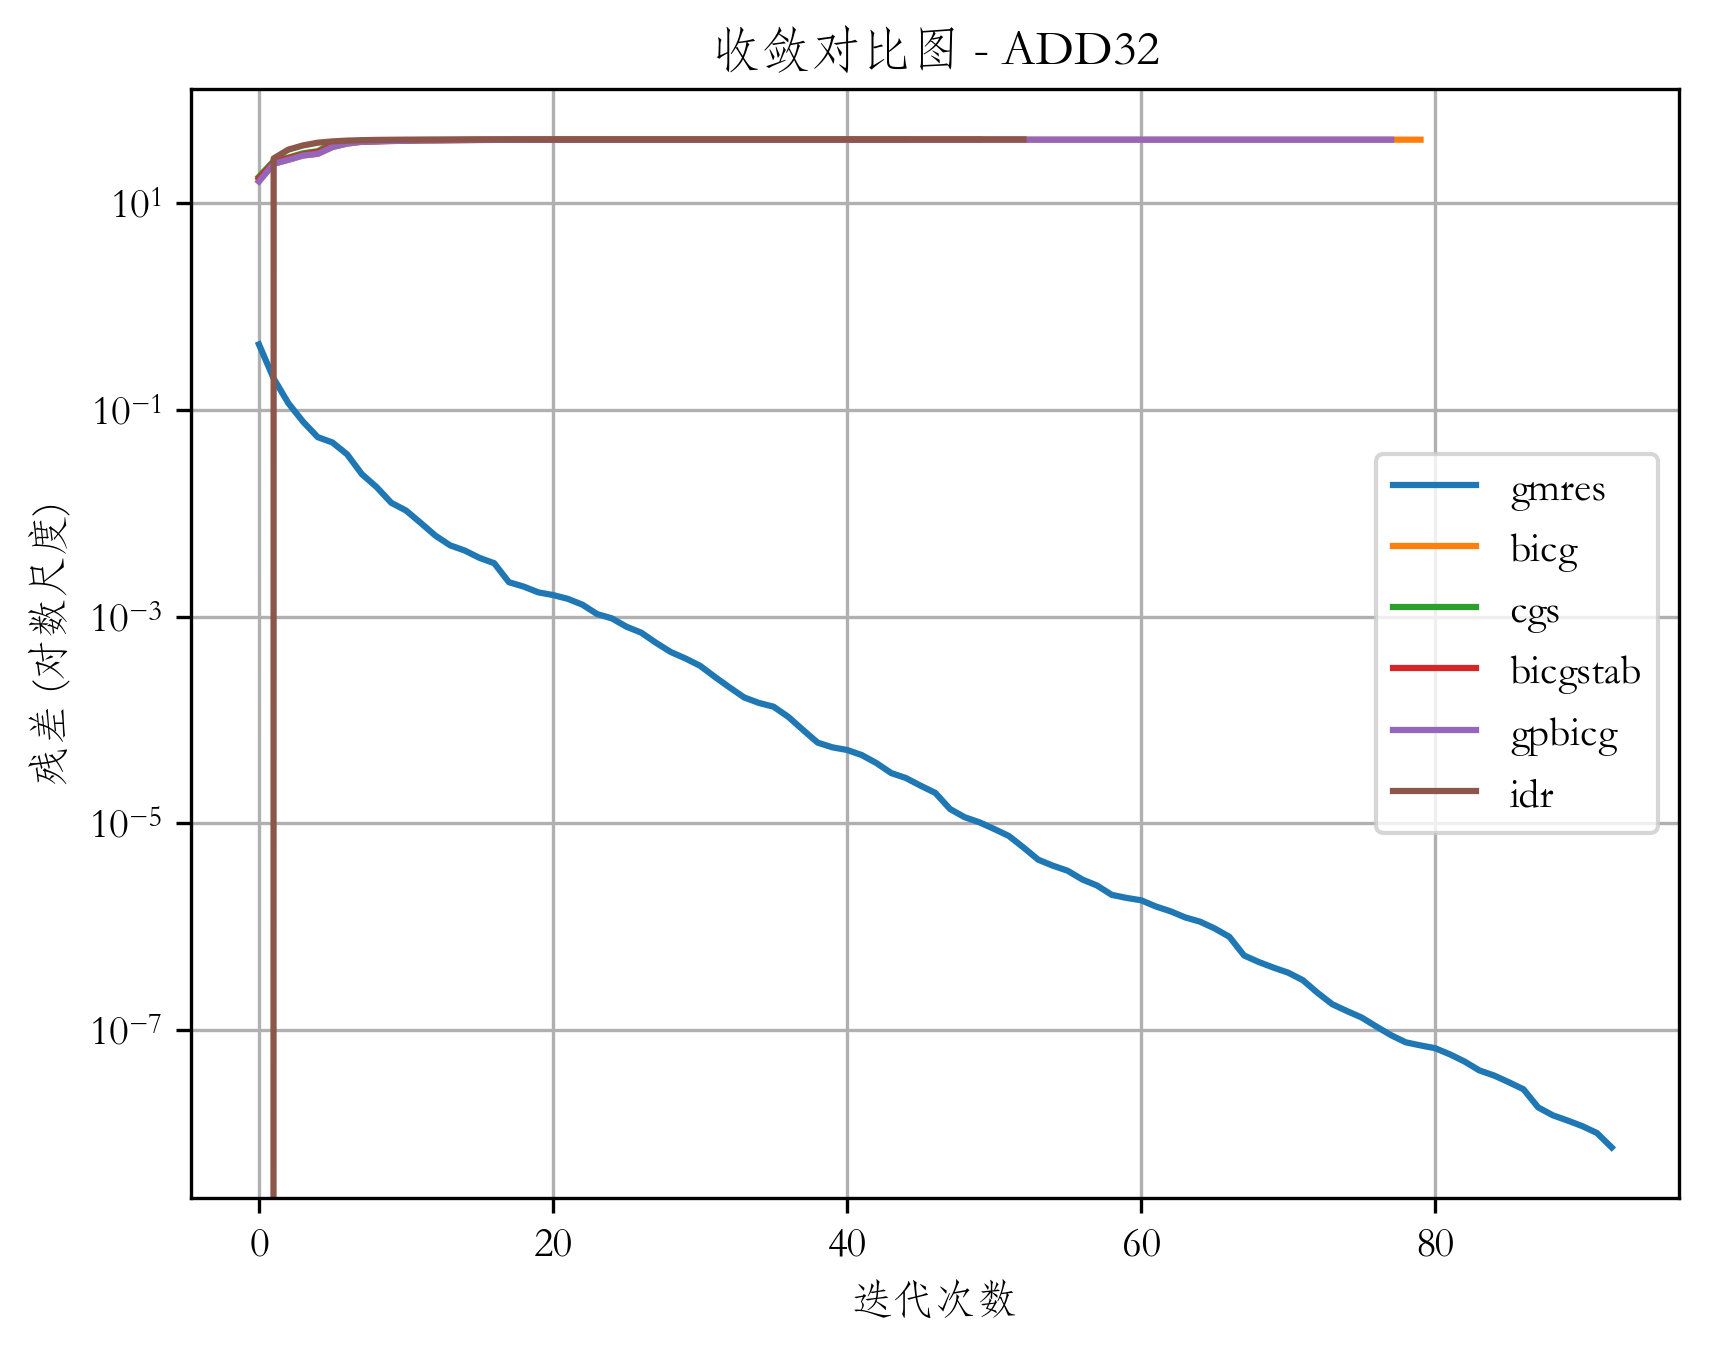

gmres   : 残差=7.36e-09, 时间=0.01s, 是否收敛=True
bicg    : 残差=6.70e-09, 时间=0.02s, 是否收敛=True
cgs     : 残差=2.06e-09, 时间=0.01s, 是否收敛=True
bicgstab: 残差=9.64e-09, 时间=0.01s, 是否收敛=True
gpbicg  : 残差=1.60e-08, 时间=0.02s, 是否收敛=True
idr     : 残差=7.74e-02, 时间=0.07s, 是否收敛=True

测试矩阵 CDDE1
961


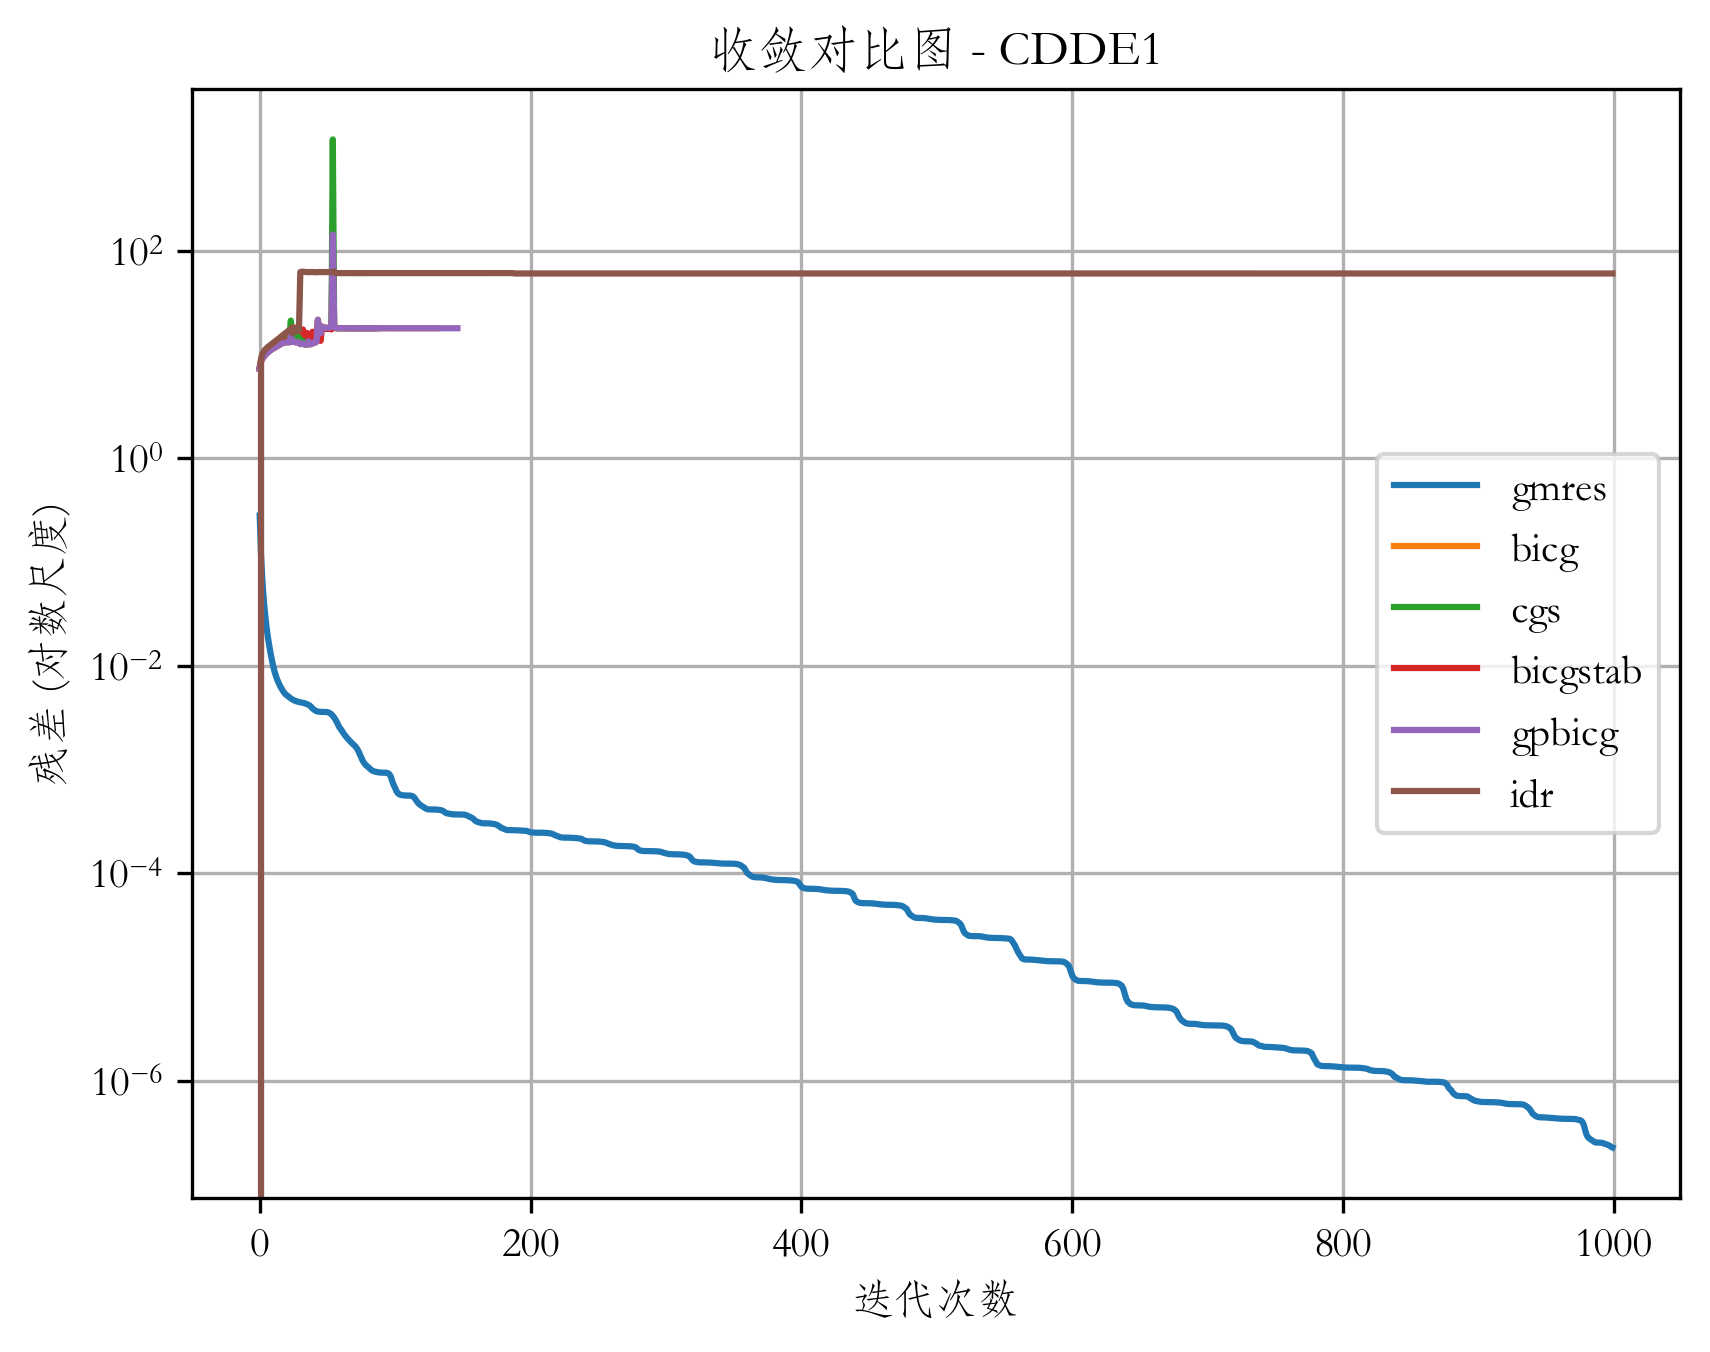

gmres   : 残差=2.29e-07, 时间=0.06s, 是否收敛=False
bicg    : 残差=6.70e-09, 时间=0.01s, 是否收敛=True
cgs     : 残差=6.15e-09, 时间=0.01s, 是否收敛=True
bicgstab: 残差=9.98e-09, 时间=0.01s, 是否收敛=True
gpbicg  : 残差=2.25e-10, 时间=0.01s, 是否收敛=True
idr     : 残差=9.06e+00, 时间=0.34s, 是否收敛=False

测试矩阵 PDE2961
2961


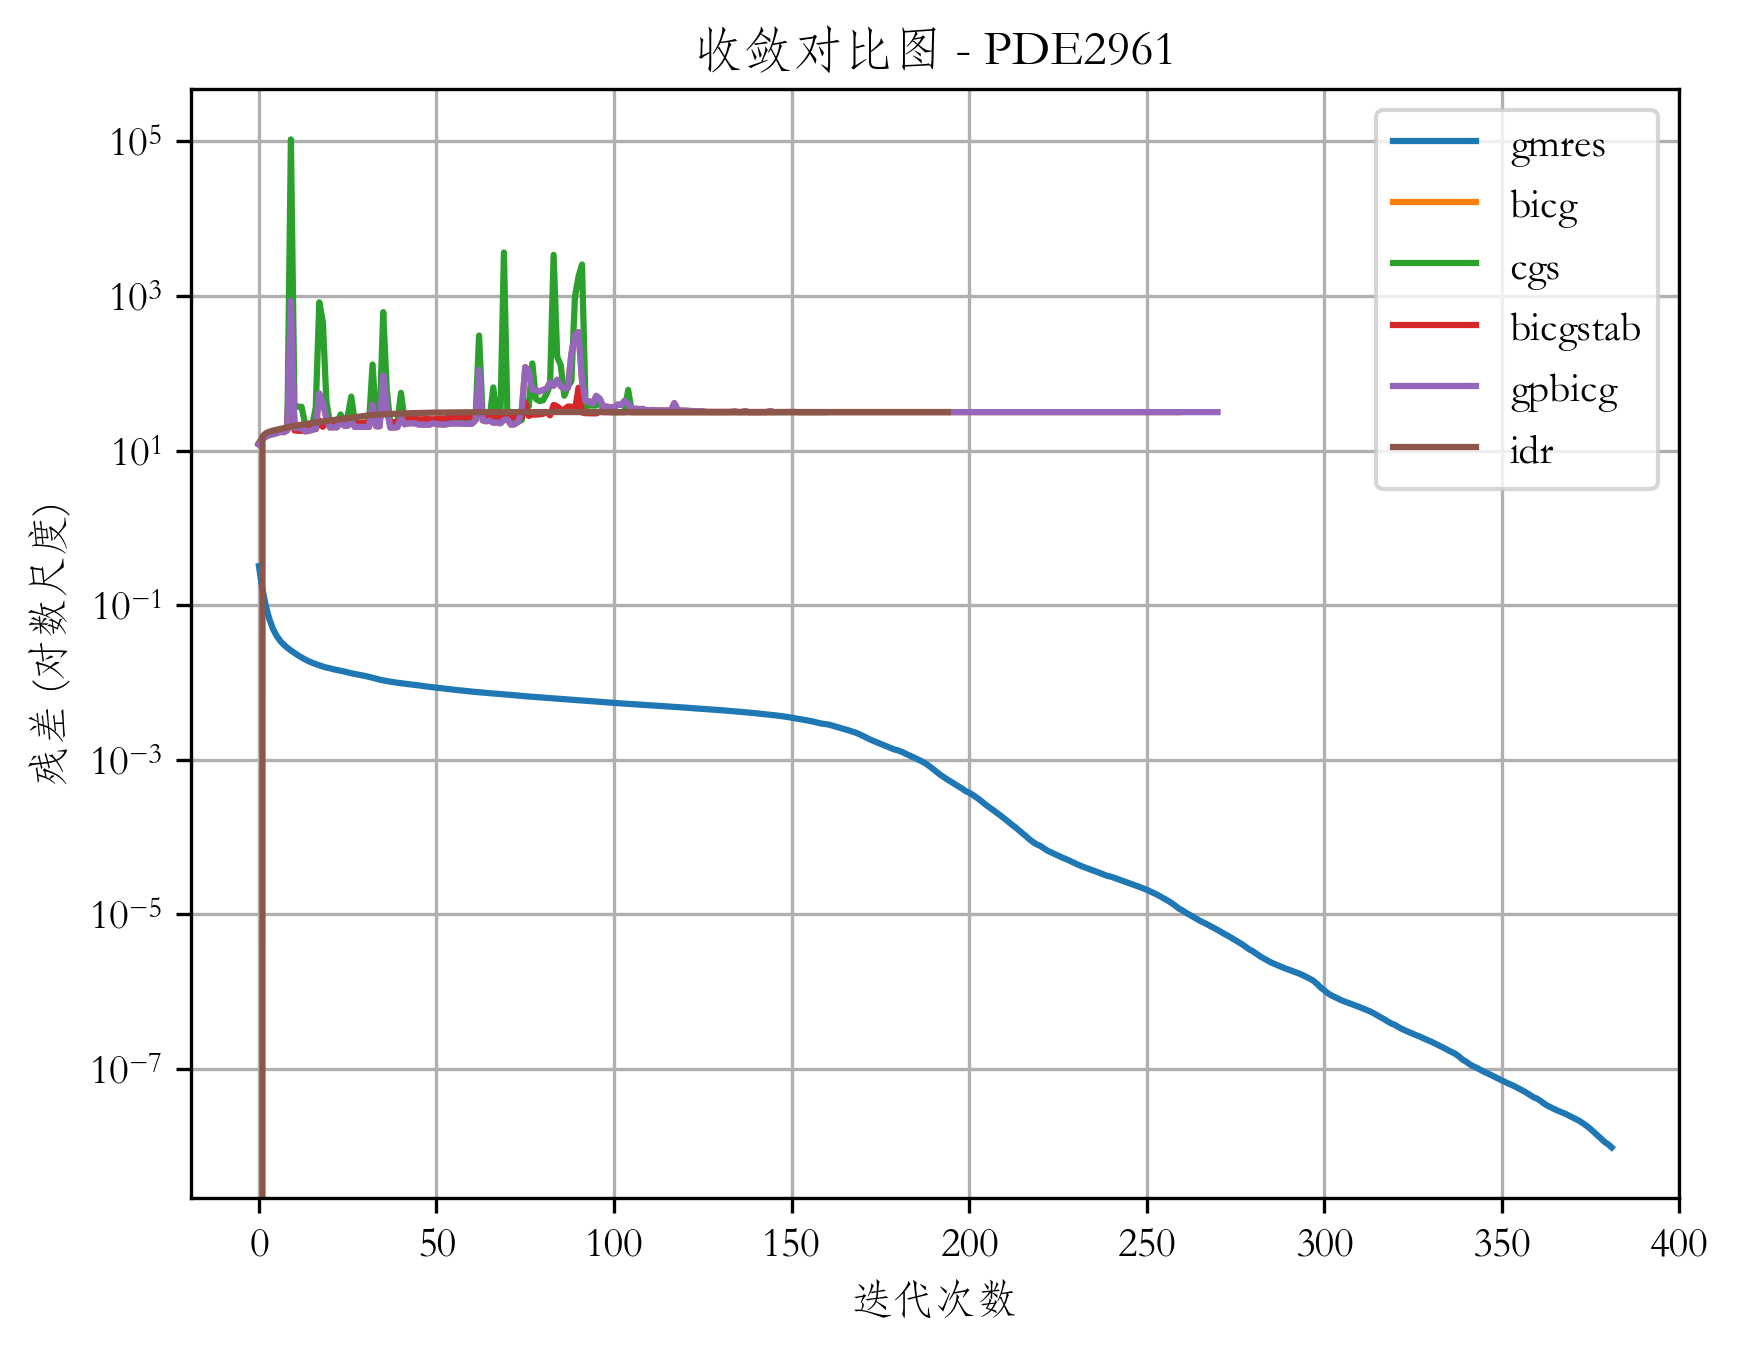

gmres   : 残差=9.68e-09, 时间=0.03s, 是否收敛=True
bicg    : 残差=8.08e-09, 时间=0.03s, 是否收敛=True
cgs     : 残差=7.87e-09, 时间=0.02s, 是否收敛=True
bicgstab: 残差=6.34e-09, 时间=0.02s, 是否收敛=True
gpbicg  : 残差=1.50e-10, 时间=0.04s, 是否收敛=True
idr     : 残差=3.89e-02, 时间=0.09s, 是否收敛=True

测试矩阵 SHERMAN5
3312


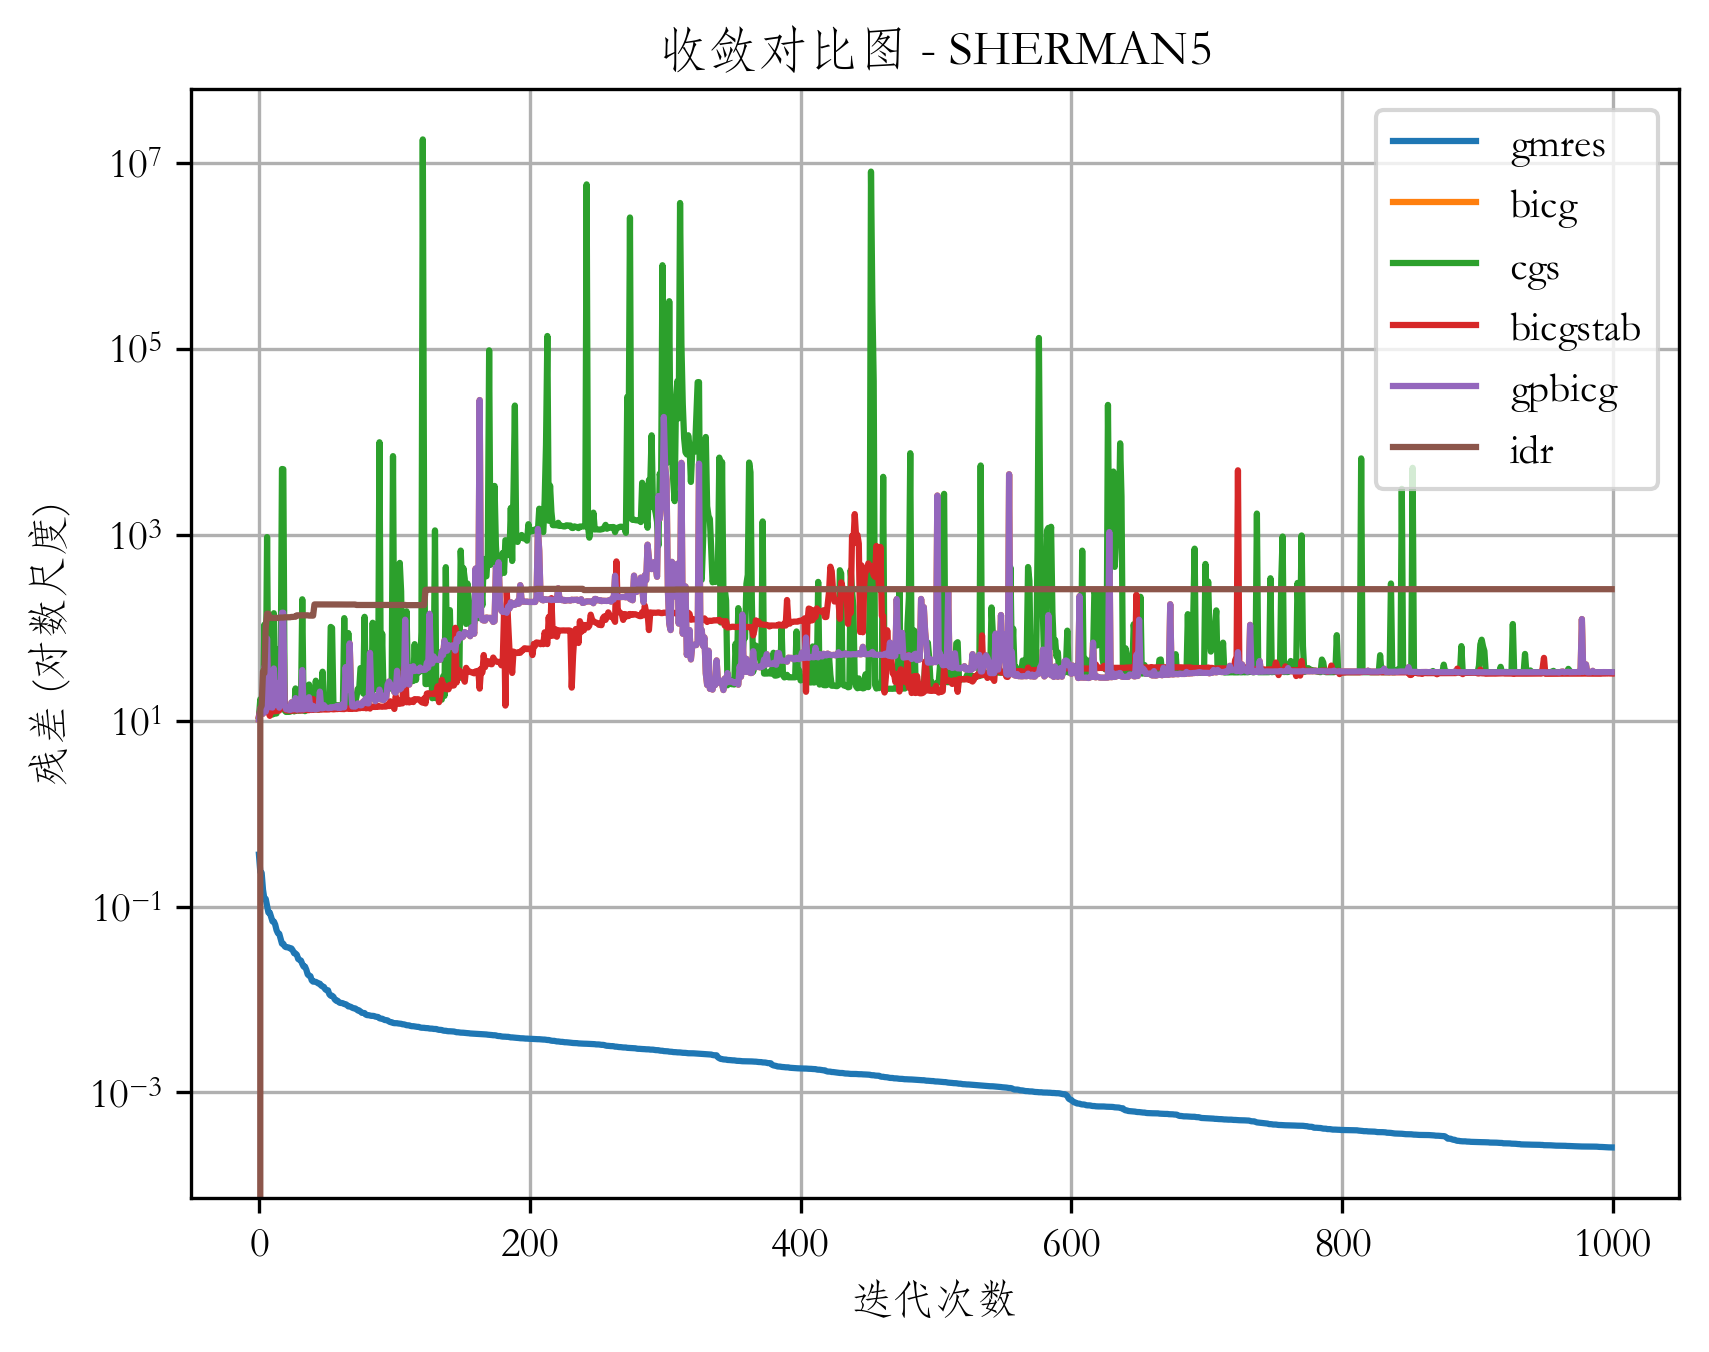

gmres   : 残差=2.56e-04, 时间=0.09s, 是否收敛=False
bicg    : 残差=5.08e-02, 时间=0.14s, 是否收敛=False
cgs     : 残差=2.29e-05, 时间=0.13s, 是否收敛=False
bicgstab: 残差=3.23e-04, 时间=0.12s, 是否收敛=False
gpbicg  : 残差=5.08e-02, 时间=0.20s, 是否收敛=False
idr     : 残差=2.60e+01, 时间=0.56s, 是否收敛=False

测试矩阵 GEMAT12
4929


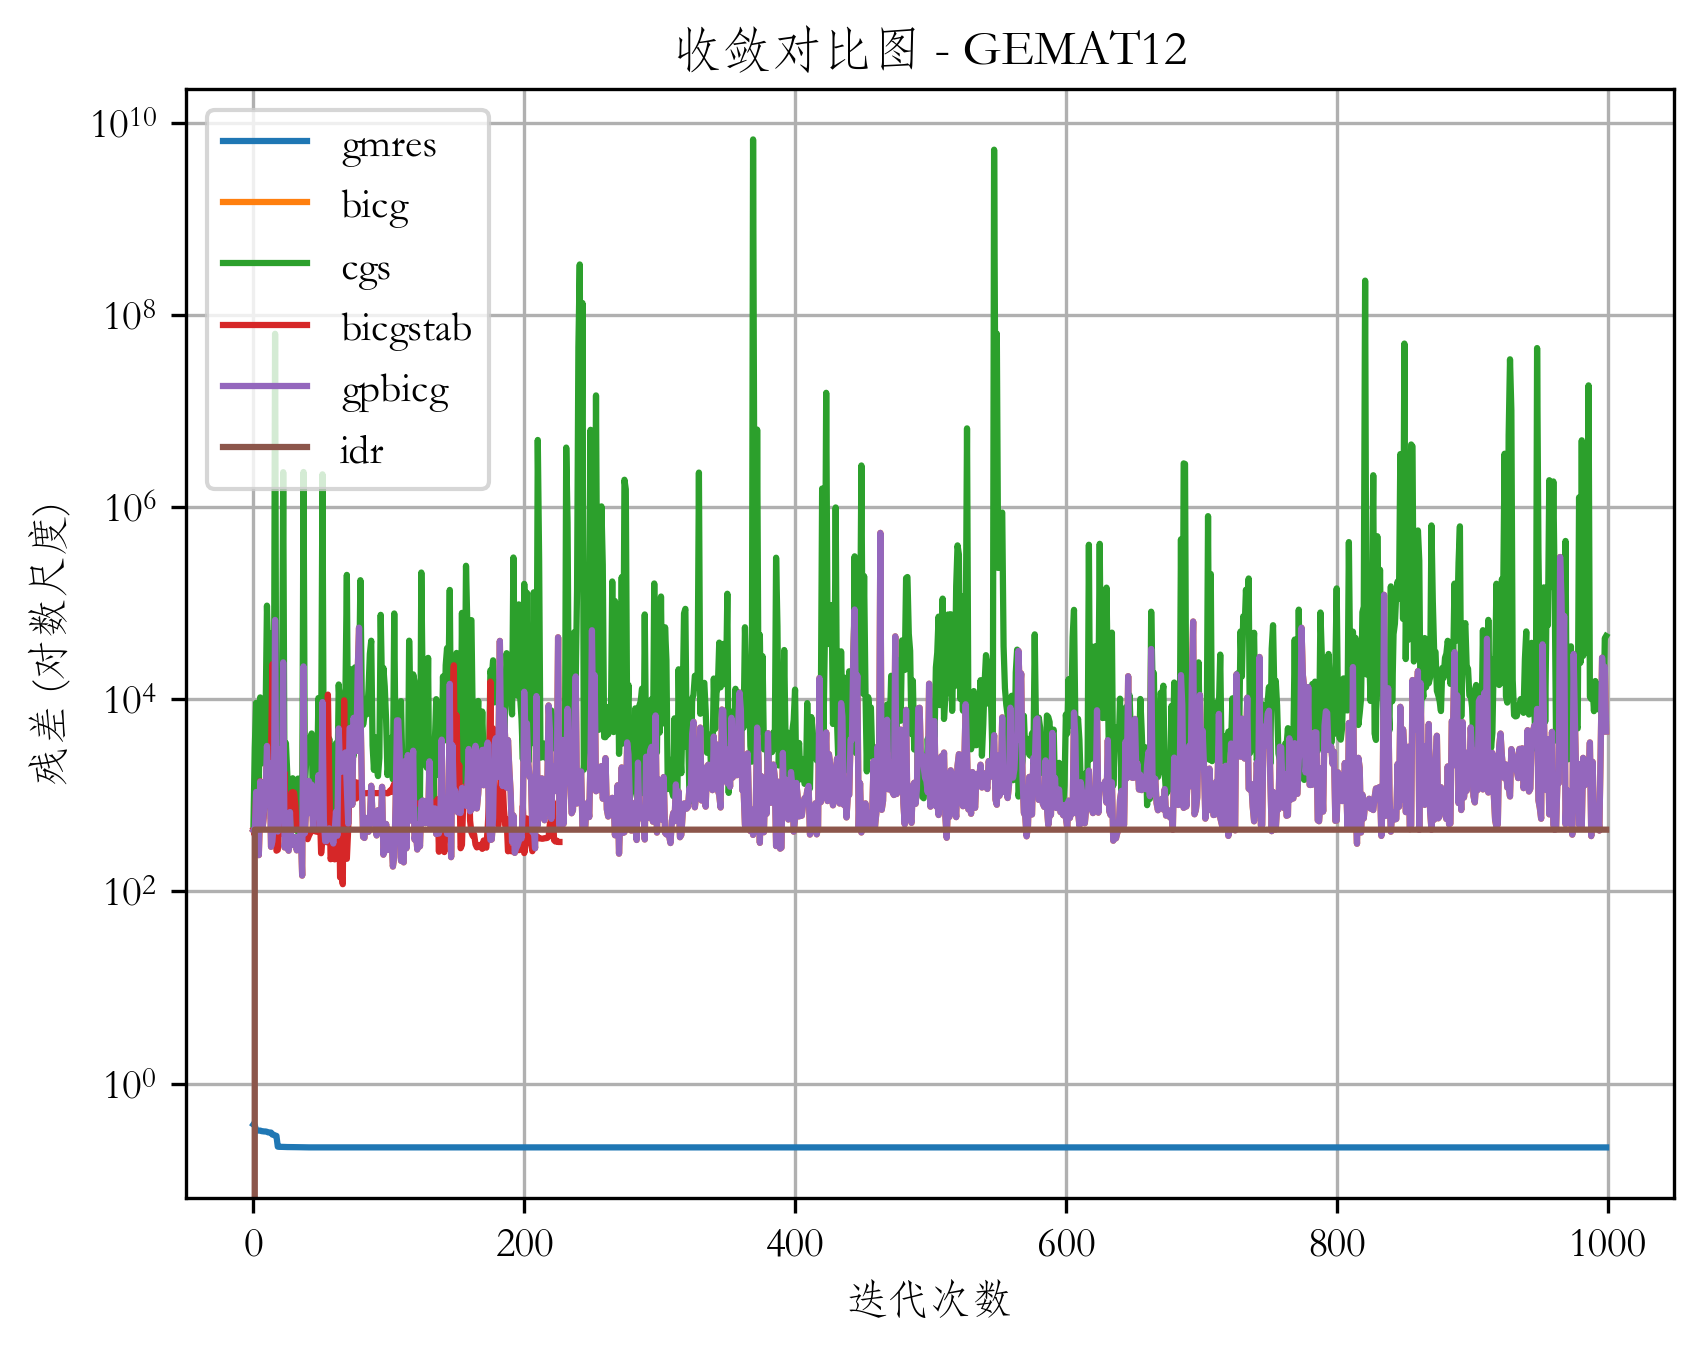

gmres   : 残差=2.17e-01, 时间=0.14s, 是否收敛=False
bicg    : 残差=6.84e+00, 时间=0.19s, 是否收敛=False
cgs     : 残差=1.54e+02, 时间=0.17s, 是否收敛=False
bicgstab: 残差=1.04e+00, 时间=0.04s, 是否收敛=False
gpbicg  : 残差=6.84e+00, 时间=0.26s, 是否收敛=False
idr     : 残差=3.36e-01, 时间=0.71s, 是否收敛=False



In [8]:
from scipy.sparse.linalg import gmres, bicg, cgs, bicgstab
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.sans-serif'] = ['STFangsong']  # 图中显示中文
plt.rcParams['axes.unicode_minus'] = False  # 图中正常显示负号
from scipy.io import mmread
import time
def gpbicg(A, b, tol=1e-8, maxiter=1000, callback=None):
    n = len(b)
    x = np.zeros(n)
    r = b - A @ x
    r_tilde = r.copy()
    p = r.copy()
    p_tilde = r_tilde.copy()
    
    residuals = []
    
    for k in range(maxiter):
        Ap = A @ p
        alpha = np.dot(r_tilde, r) / np.dot(p_tilde, Ap)
        x += alpha * p
        r_new = r - alpha * Ap
        
        if callback is not None:
            callback(x)
        
        residual_norm = np.linalg.norm(r_new)
        residuals.append(residual_norm)
        
        if residual_norm < tol:
            return x, 0
        
        r_tilde_new = r_tilde - alpha * (A.T @ p_tilde)
        beta = np.dot(r_tilde_new, r_new) / np.dot(r_tilde, r)
        p = r_new + beta * p
        p_tilde = r_tilde_new + beta * p_tilde
        
        r = r_new
        r_tilde = r_tilde_new
    
    return x, maxiter

def idr(A, b, s=4, tol=1e-8, maxiter=1000, callback=None):
    n = len(b)
    x = np.zeros(n)
    r = b - A @ x
    residuals = []
    
    G = np.zeros((n, s))
    U = np.zeros((n, s))
    
    for k in range(maxiter):
        if callback is not None:
            callback(x)
        
        residual_norm = np.linalg.norm(r)
        residuals.append(residual_norm)
        
        if residual_norm < tol:
            return x, 0
        
        v = r
        for i in range(s):
            G[:, i] = A @ v
            omega = np.dot(G[:, i], r) / np.dot(G[:, i], G[:, i])
            x += omega * v
            r -= omega * G[:, i]
            
            if np.linalg.norm(r) < tol:
                return x, 0
            
            U[:, i] = v
            v = r - np.dot(G[:, i], r) / np.dot(G[:, i], G[:, i]) * G[:, i]
        
        # 使用伪逆代替逆矩阵
        M = np.linalg.pinv(G.T @ G) @ G.T
        c = M @ r
        x += U @ c
        r -= G @ c
    
    return x, maxiter
def solve_and_measure(A, b, method, tol=1e-8, maxiter=1000):
    start_time = time.time()
    callback, residuals = callback_factory()
    
    if method == 'gmres':
        x, info = gmres(A, b, tol=tol, maxiter=maxiter, callback=callback)
    elif method == 'bicg':
        x, info = bicg(A, b, tol=tol, maxiter=maxiter, callback=callback)
    elif method == 'cgs':
        x, info = cgs(A, b, tol=tol, maxiter=maxiter, callback=callback)
    elif method == 'bicgstab':
        x, info = bicgstab(A, b, tol=tol, maxiter=maxiter, callback=callback)
    elif method == 'gpbicg':
        x, info = gpbicg(A, b, tol=tol, maxiter=maxiter, callback=callback)
    elif method == 'idr':
        x, info = idr(A, b, s=4, tol=tol, maxiter=maxiter, callback=callback)
    
    elapsed_time = time.time() - start_time
    final_residual = np.linalg.norm(A @ x - b) / np.linalg.norm(b)
    
    return x, final_residual, elapsed_time, info, residuals

def callback_factory():
    residuals = []
    def callback(xk):
        residuals.append(np.linalg.norm(xk))
        return False
    return callback, residuals

def plot_convergence(results, matrix_name):
    plt.figure()
    for method, data in results.items():
        residuals = data['residuals']
        iterations = range(len(residuals))
        plt.semilogy(iterations, residuals, label=method)
    
    plt.title(f'收敛对比图 - {matrix_name}')
    plt.xlabel('迭代次数')
    plt.ylabel('残差 (对数尺度)')
    plt.grid(True)
    plt.legend()
    plt.show()

def load_matrix(matrix_name, matrix_dir="./matrices"):
    filepath = os.path.join(matrix_dir, f"{matrix_name}.mtx")
    return mmread(filepath)

def run_experiments(matrix_dir="./matrices"):
    test_cases = ['ADD32', 'CDDE1', 'PDE2961', 'SHERMAN5', 'GEMAT12']
    methods = ['gmres', 'bicg', 'cgs', 'bicgstab', 'gpbicg', 'idr']
    
    all_results = {}
    for name in test_cases:
        print(f"测试矩阵 {name}")
        A = load_matrix(name, matrix_dir)
        n = A.shape[0]
        print(n)
        x_true = np.random.rand(n)
        b = A @ x_true
        
        results = {}
        for method in methods:
            x, residual, time_taken, info, residuals = solve_and_measure(A, b, method)
            results[method] = {
                'residual': residual,
                'time': time_taken,
                'converged': info == 0,
                'residuals': residuals
            }
        
        plot_convergence(results, name)
        all_results[name] = results
        
        for method, data in results.items():
            print(f"{method:8s}: 残差={data['residual']:.2e}, "
                  f"时间={data['time']:.2f}s, "
                  f"是否收敛={data['converged']}")
        print()
    
    return all_results

results = run_experiments()

测试矩阵 ADD32


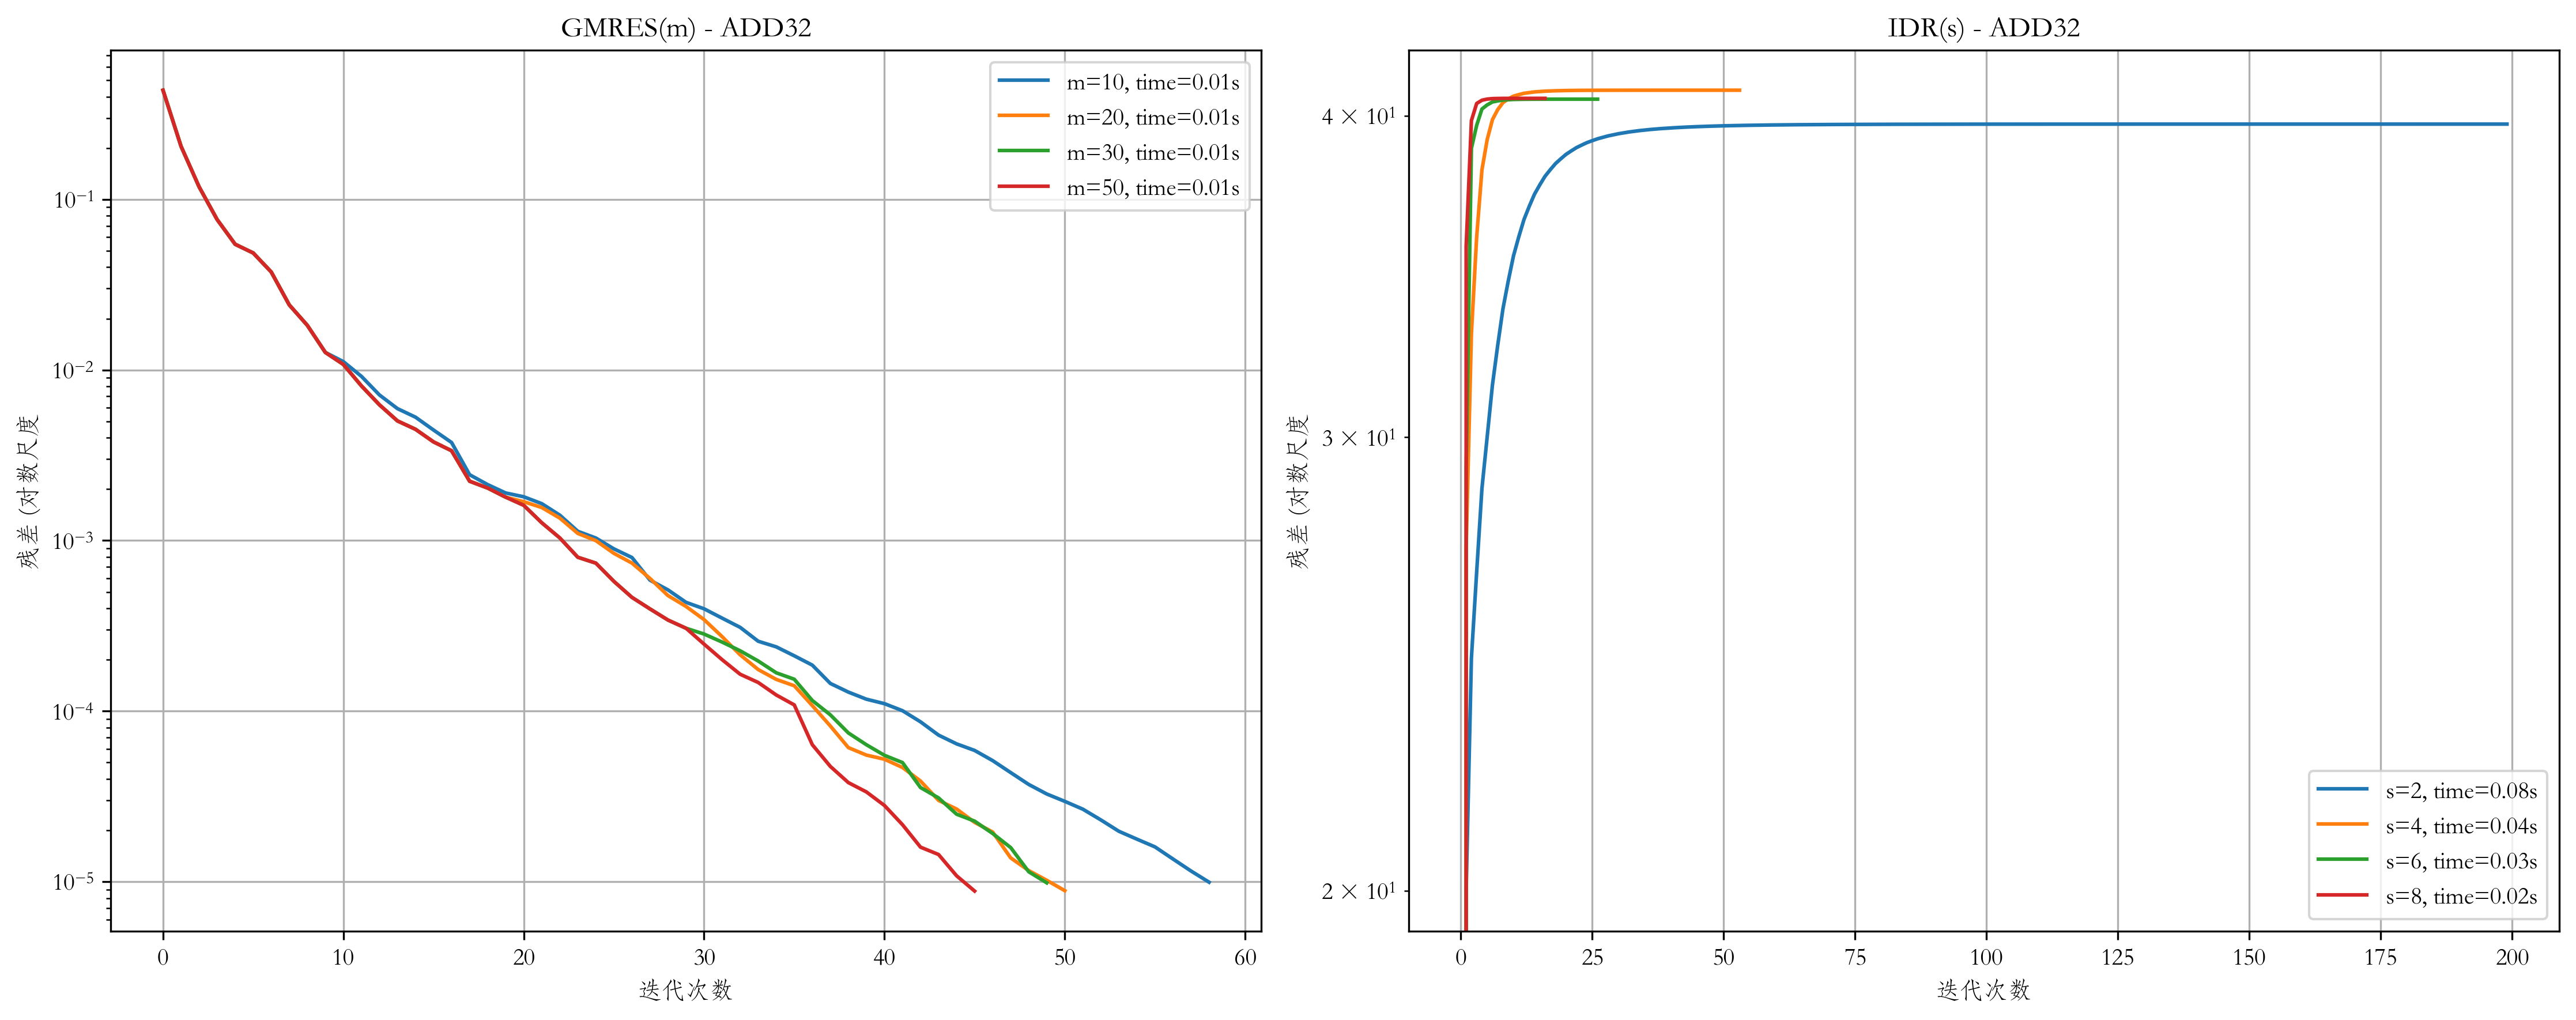

测试矩阵 CDDE1


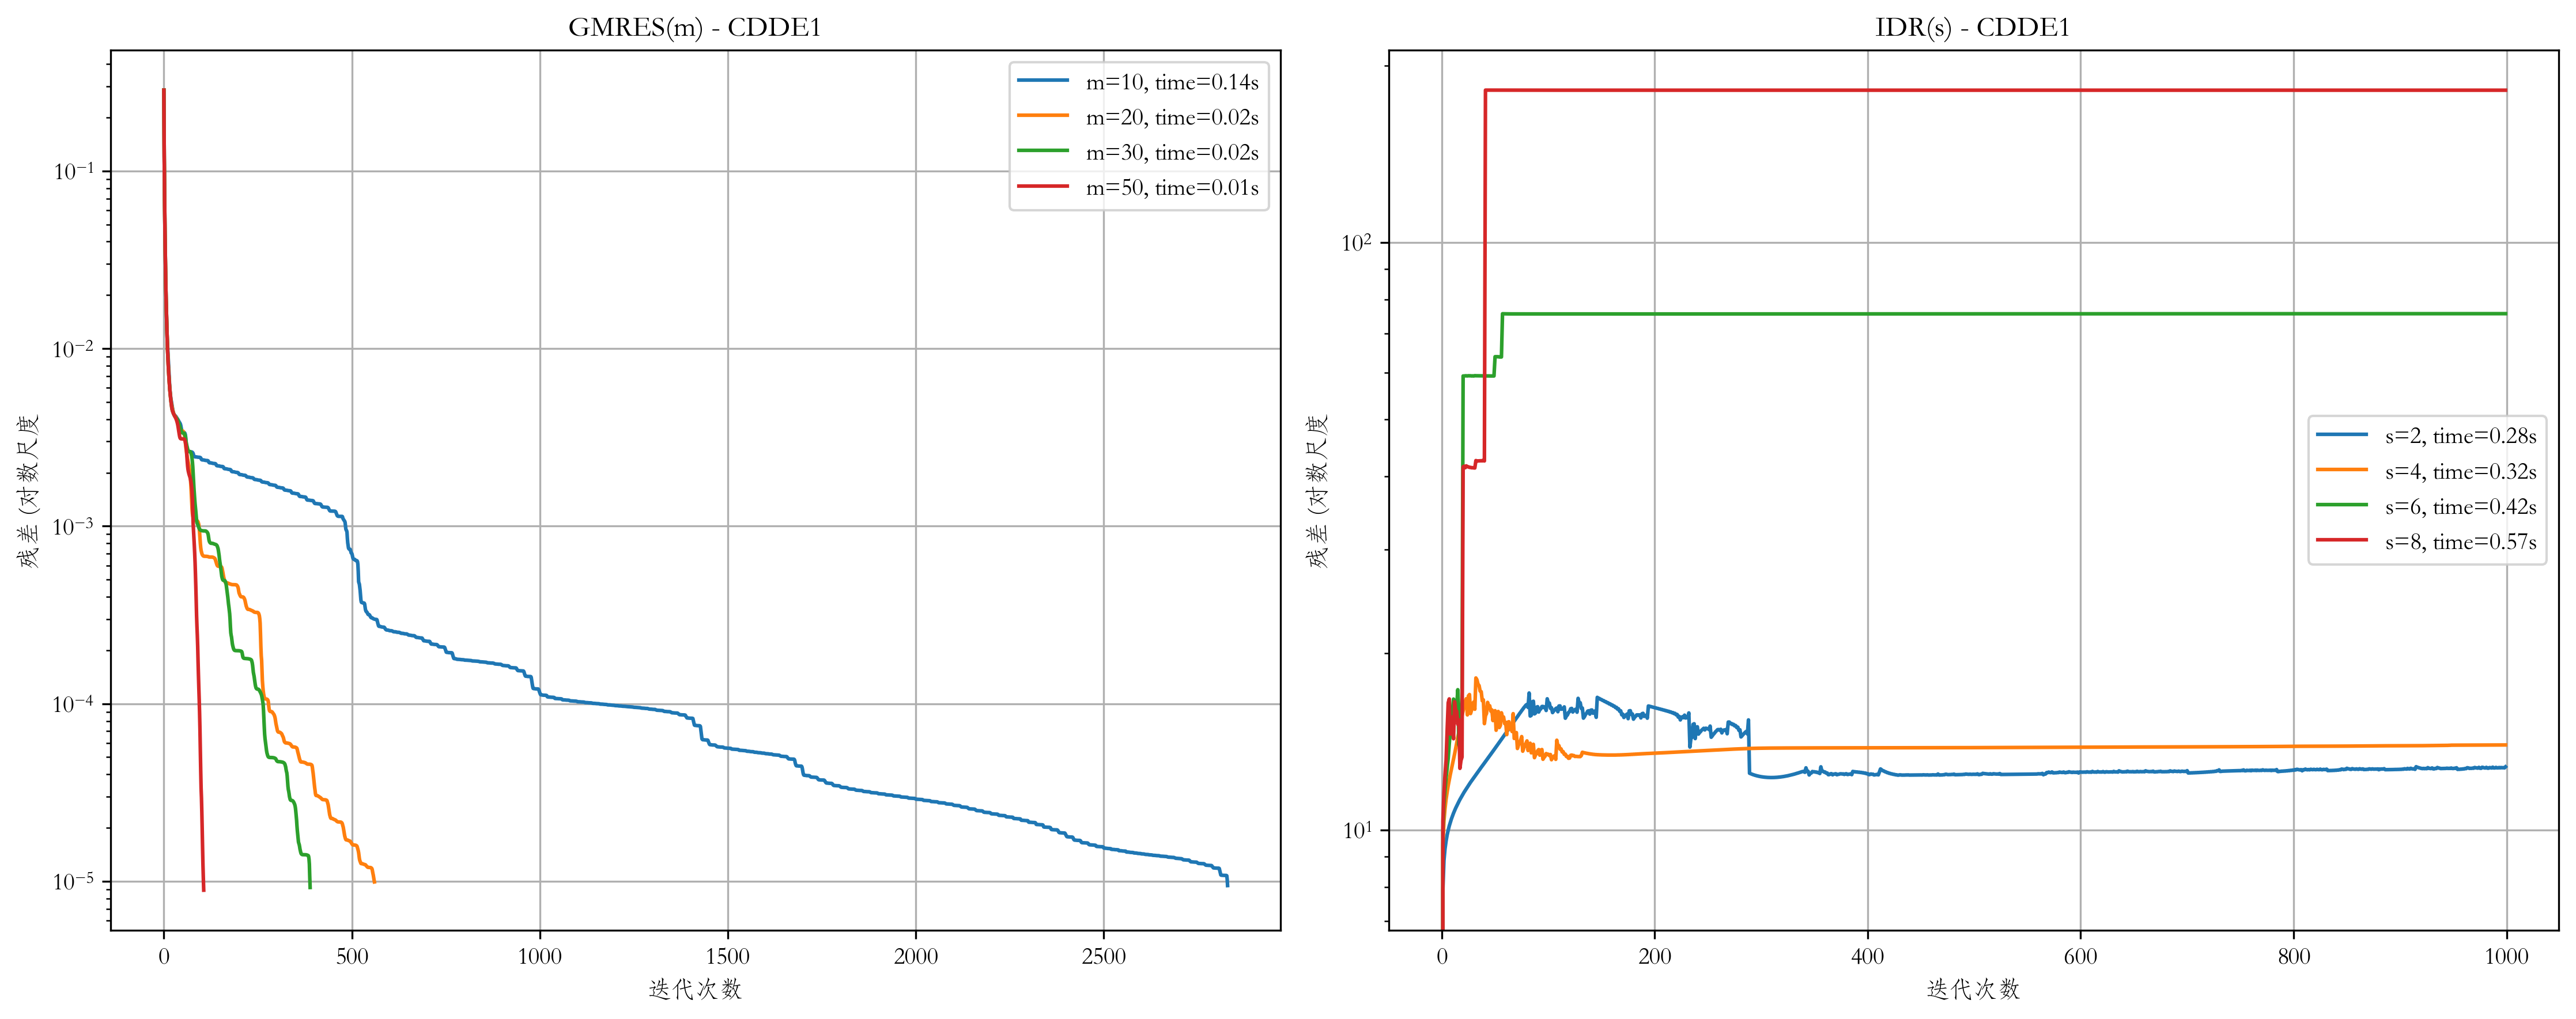

测试矩阵 PDE2961


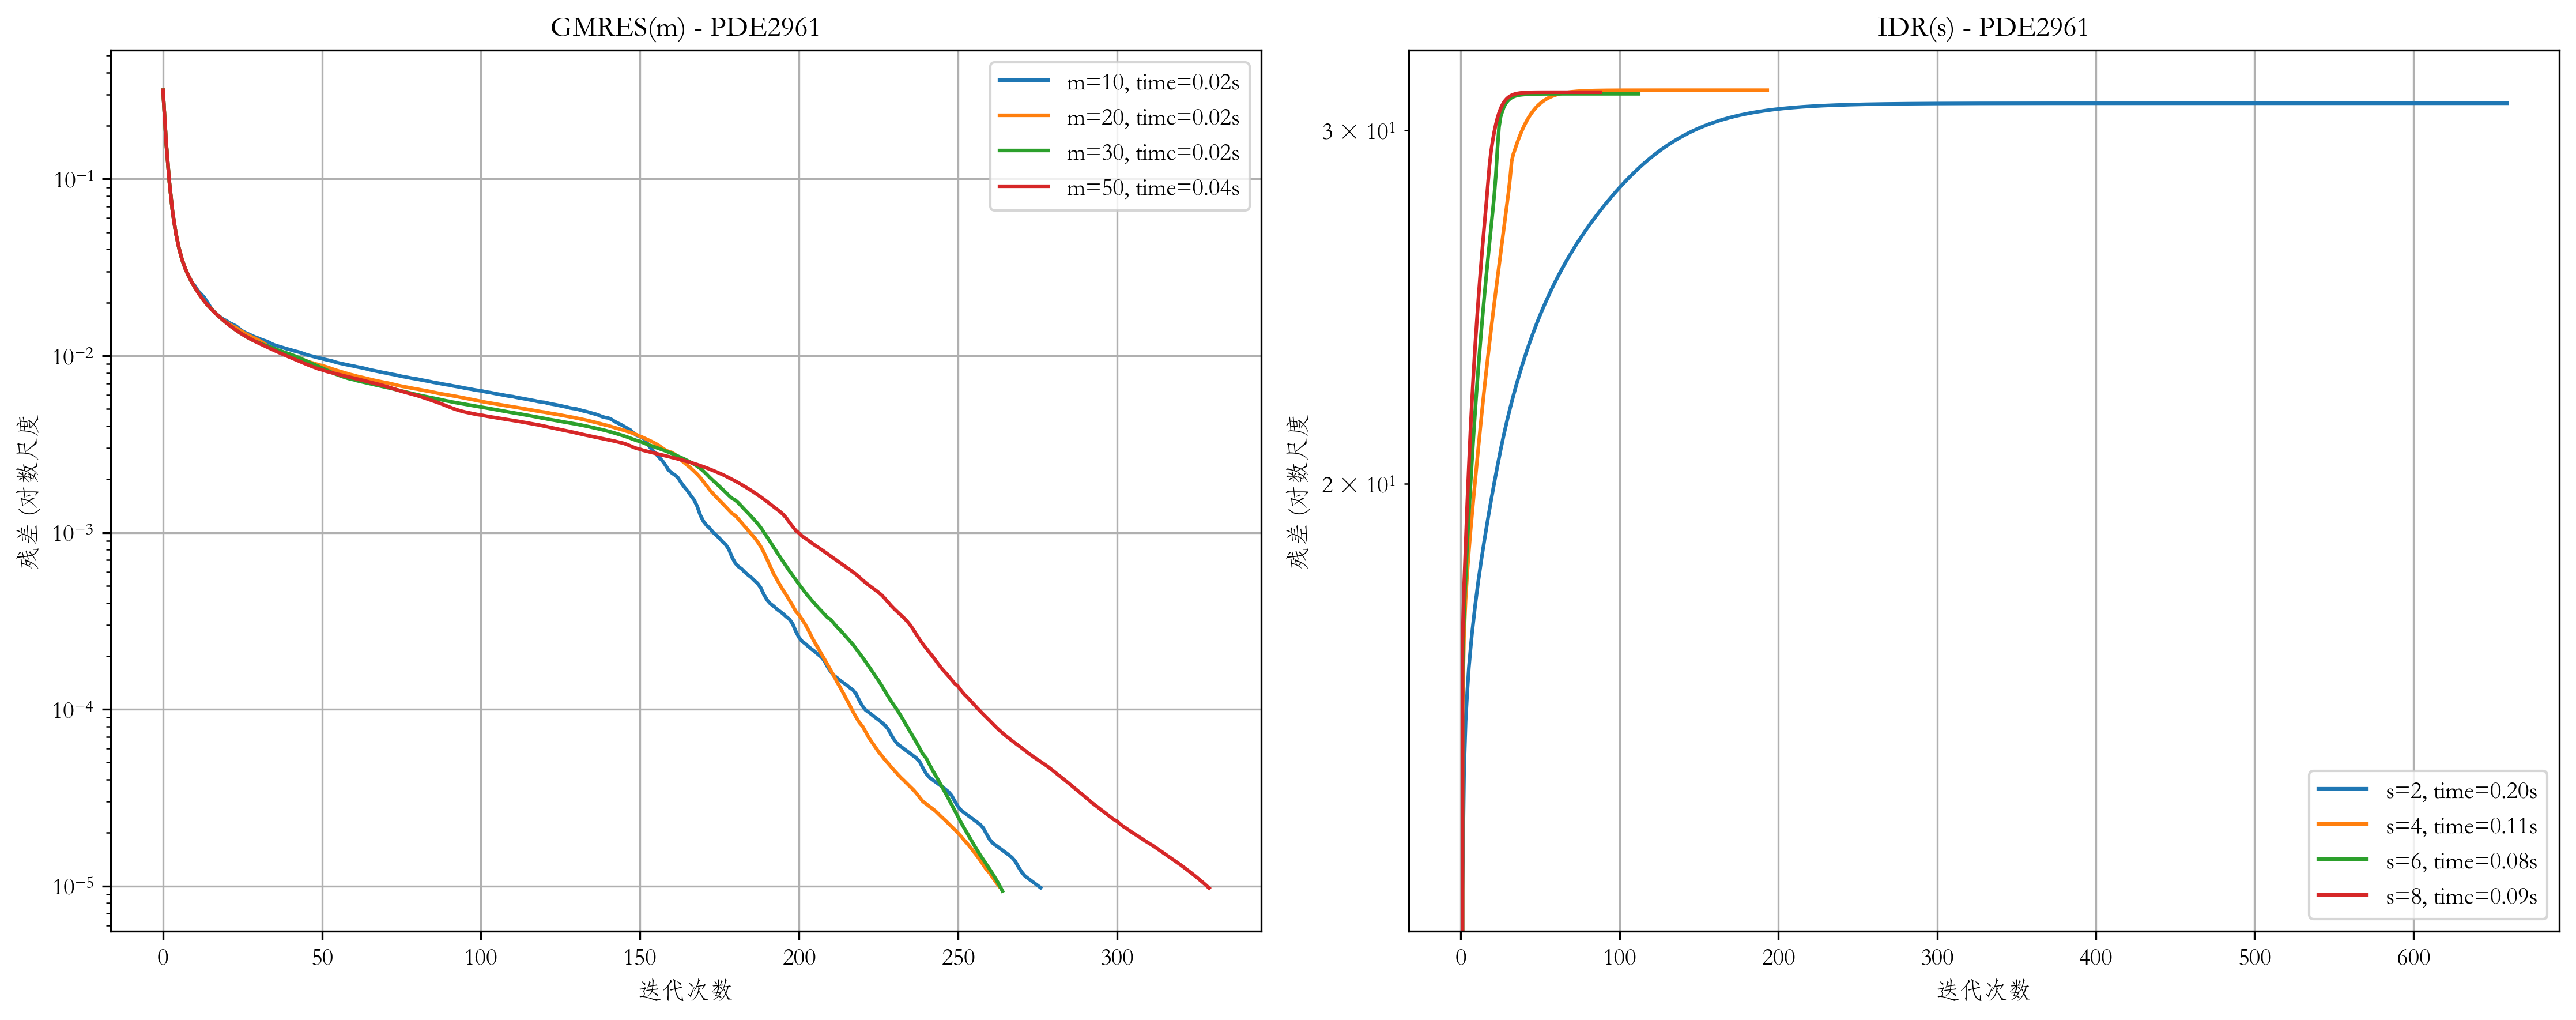

测试矩阵 SHERMAN5


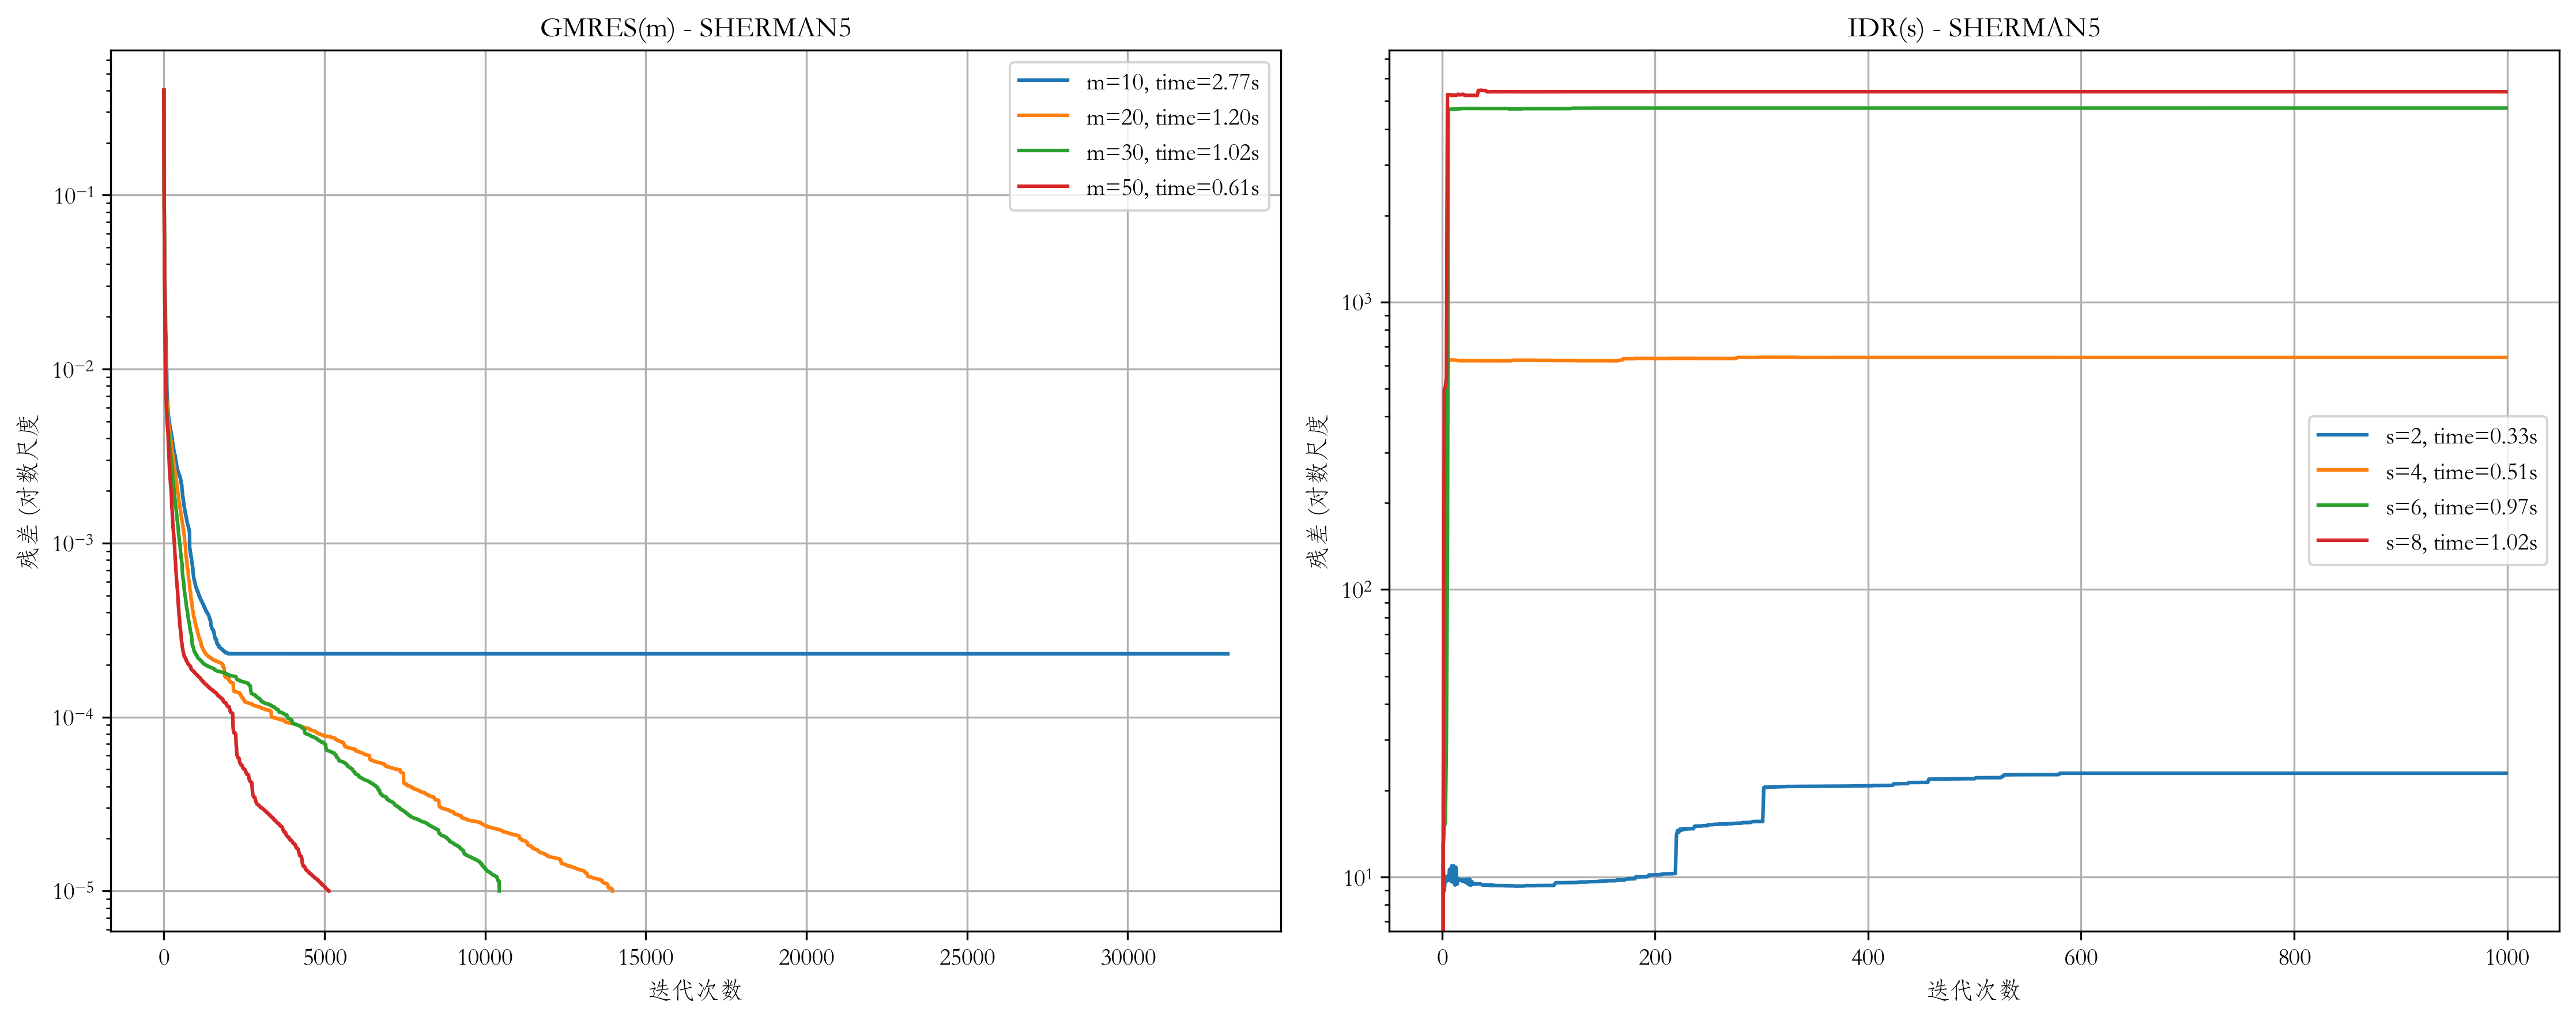

测试矩阵 GEMAT12


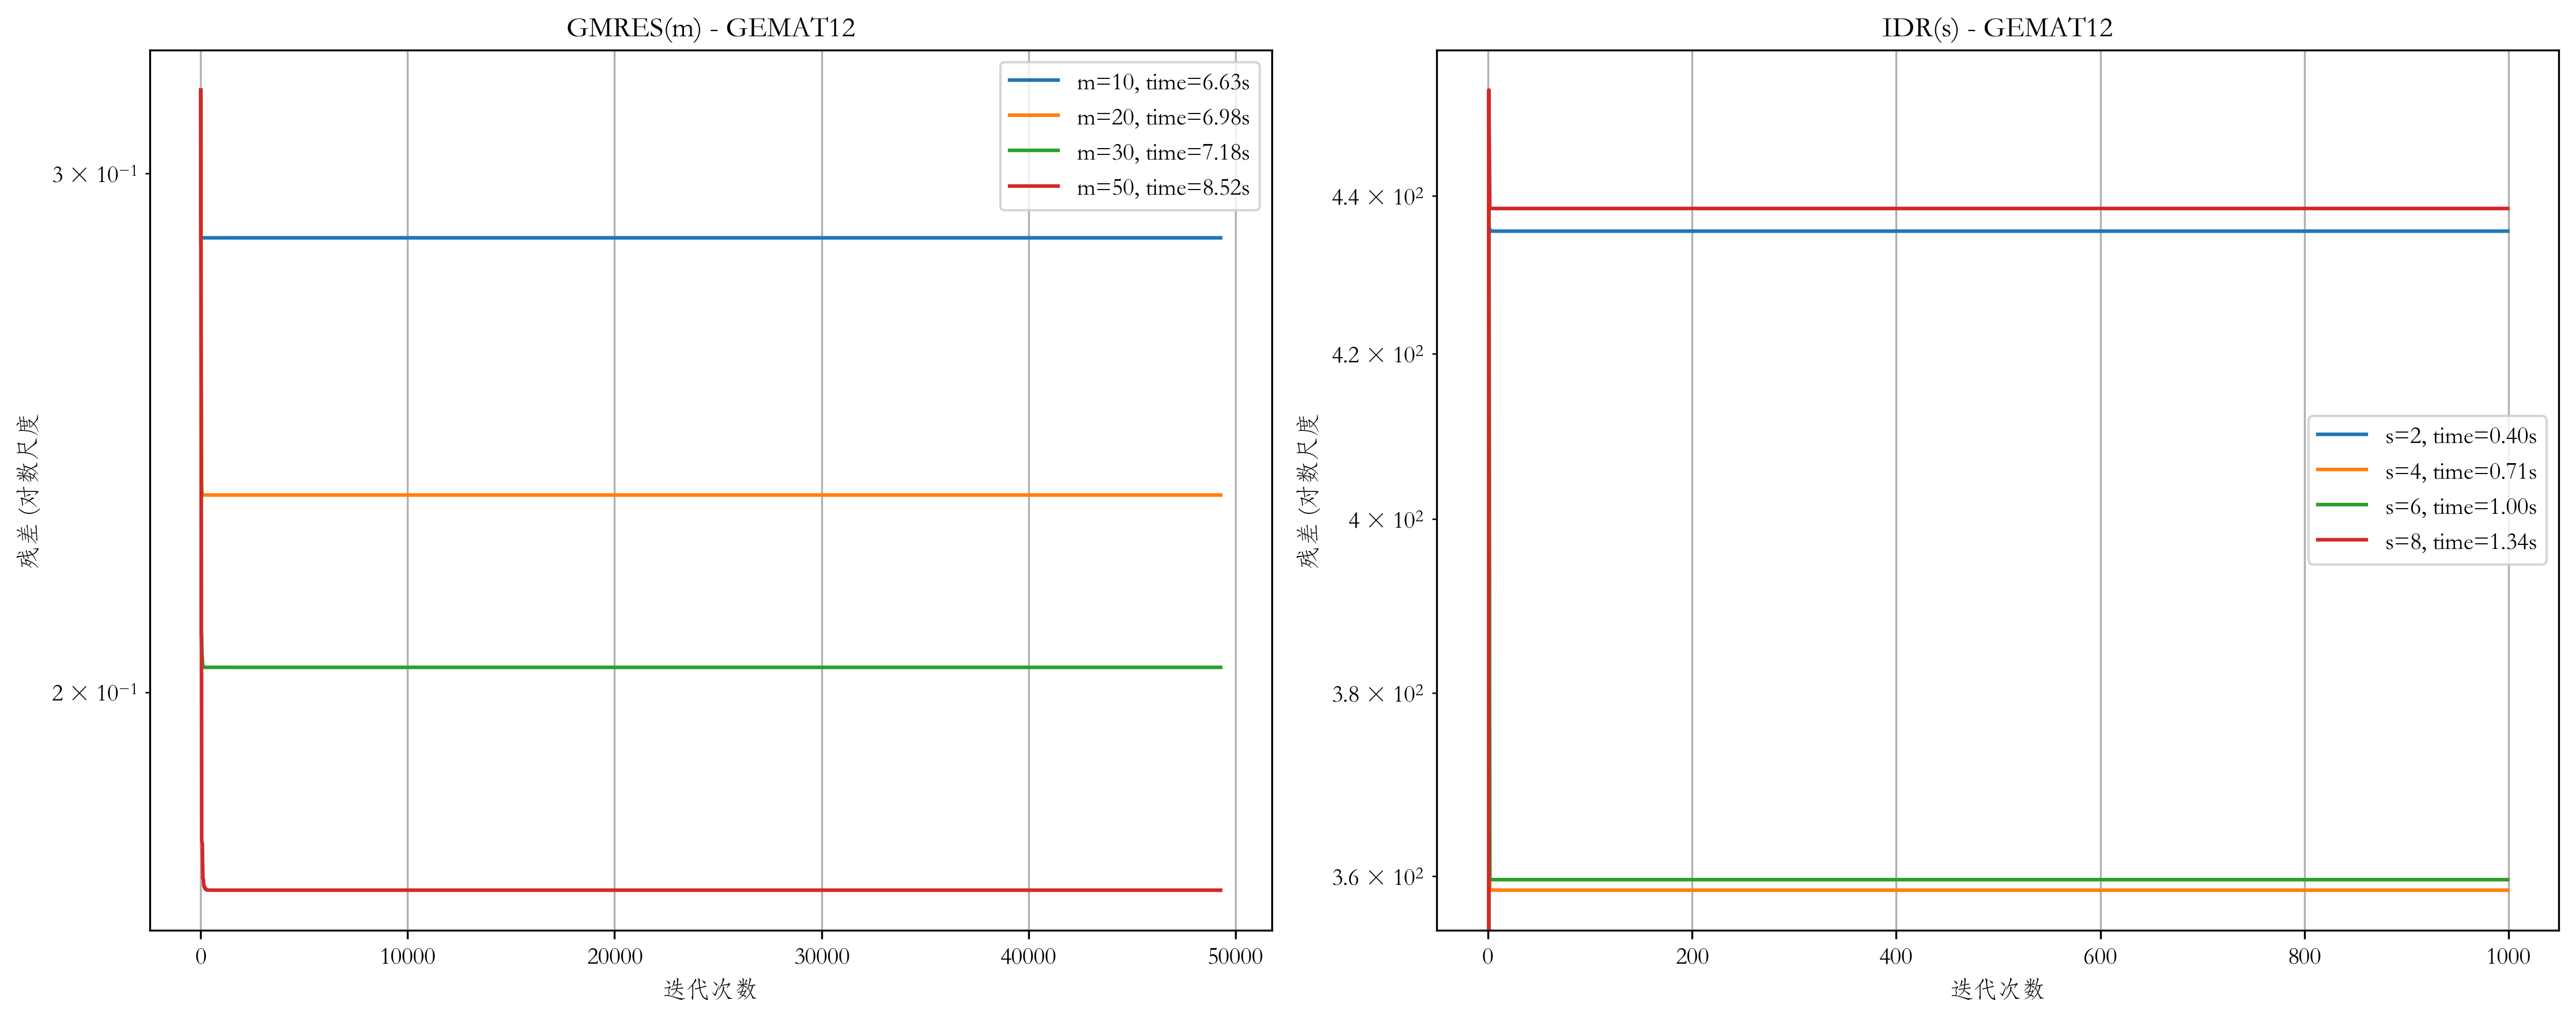

In [9]:
from scipy.sparse.linalg import gmres
import matplotlib.pyplot as plt
from scipy.io import mmread
import time
import os

import numpy as np


def callback_factory():
    residuals = []
    def callback(xk):
        residuals.append(np.linalg.norm(xk))
        return False
    return callback, residuals

def compare_parameters(A, b, matrix_name):
    m_values = [10, 20, 30, 50]  # GMRES重启参数
    s_values = [2, 4, 6, 8]      # IDR参数
    
    plt.figure(figsize=(15, 6))
    
    # GMRES(m)对比
    plt.subplot(121)
    for m in m_values:
        callback, residuals = callback_factory()
        start_time = time.time()
        x, info = gmres(A, b, restart=m, callback=callback)
        time_taken = time.time() - start_time
        iterations = range(len(residuals))
        plt.semilogy(iterations, residuals, label=f'm={m}, time={time_taken:.2f}s')
    
    plt.title(f'GMRES(m) - {matrix_name}')
    plt.xlabel('迭代次数')
    plt.ylabel('残差 (对数尺度')
    plt.grid(True)
    plt.legend()
    
    # IDR(s)对比
    plt.subplot(122)
    for s in s_values:
        callback, residuals = callback_factory()
        start_time = time.time()
        x, info = idr(A, b, s=s, callback=callback)
        time_taken = time.time() - start_time
        iterations = range(len(residuals))
        plt.semilogy(iterations, residuals, label=f's={s}, time={time_taken:.2f}s')
    
    plt.title(f'IDR(s) - {matrix_name}')
    plt.xlabel('迭代次数')
    plt.ylabel('残差 (对数尺度')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def run_parameter_comparison(matrix_dir="./matrices"):
    test_cases = ['ADD32', 'CDDE1', 'PDE2961', 'SHERMAN5', 'GEMAT12']
    
    for name in test_cases:
        print(f"测试矩阵 {name}")
        A = mmread(os.path.join(matrix_dir, f"{name}.mtx"))
        n = A.shape[0]
        x_true = np.random.rand(n)
        b = A @ x_true
        
        compare_parameters(A, b, name)

run_parameter_comparison()

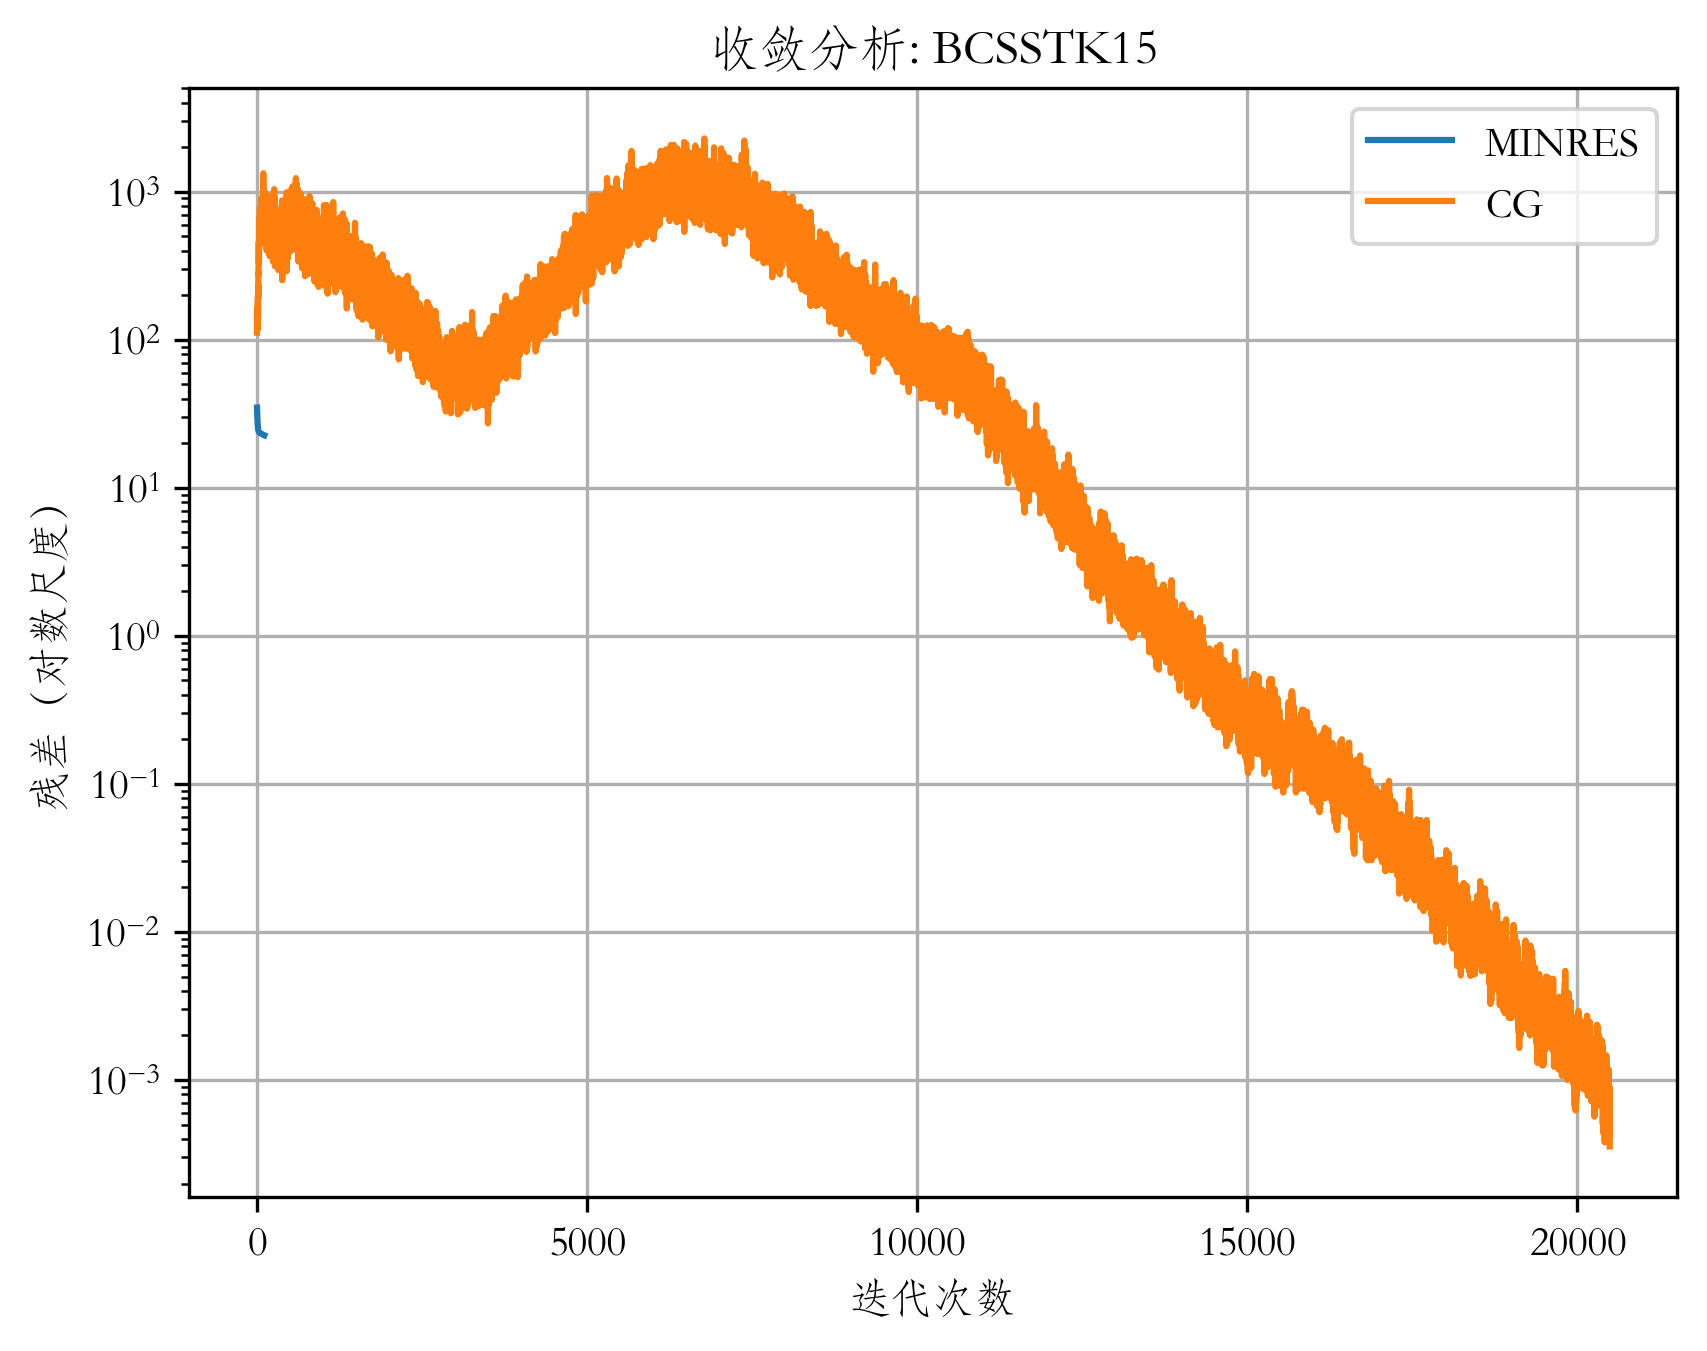

Matrix: BCSSTK15
MINRES Time: 0.030345 seconds
CG Time: 4.747867 seconds



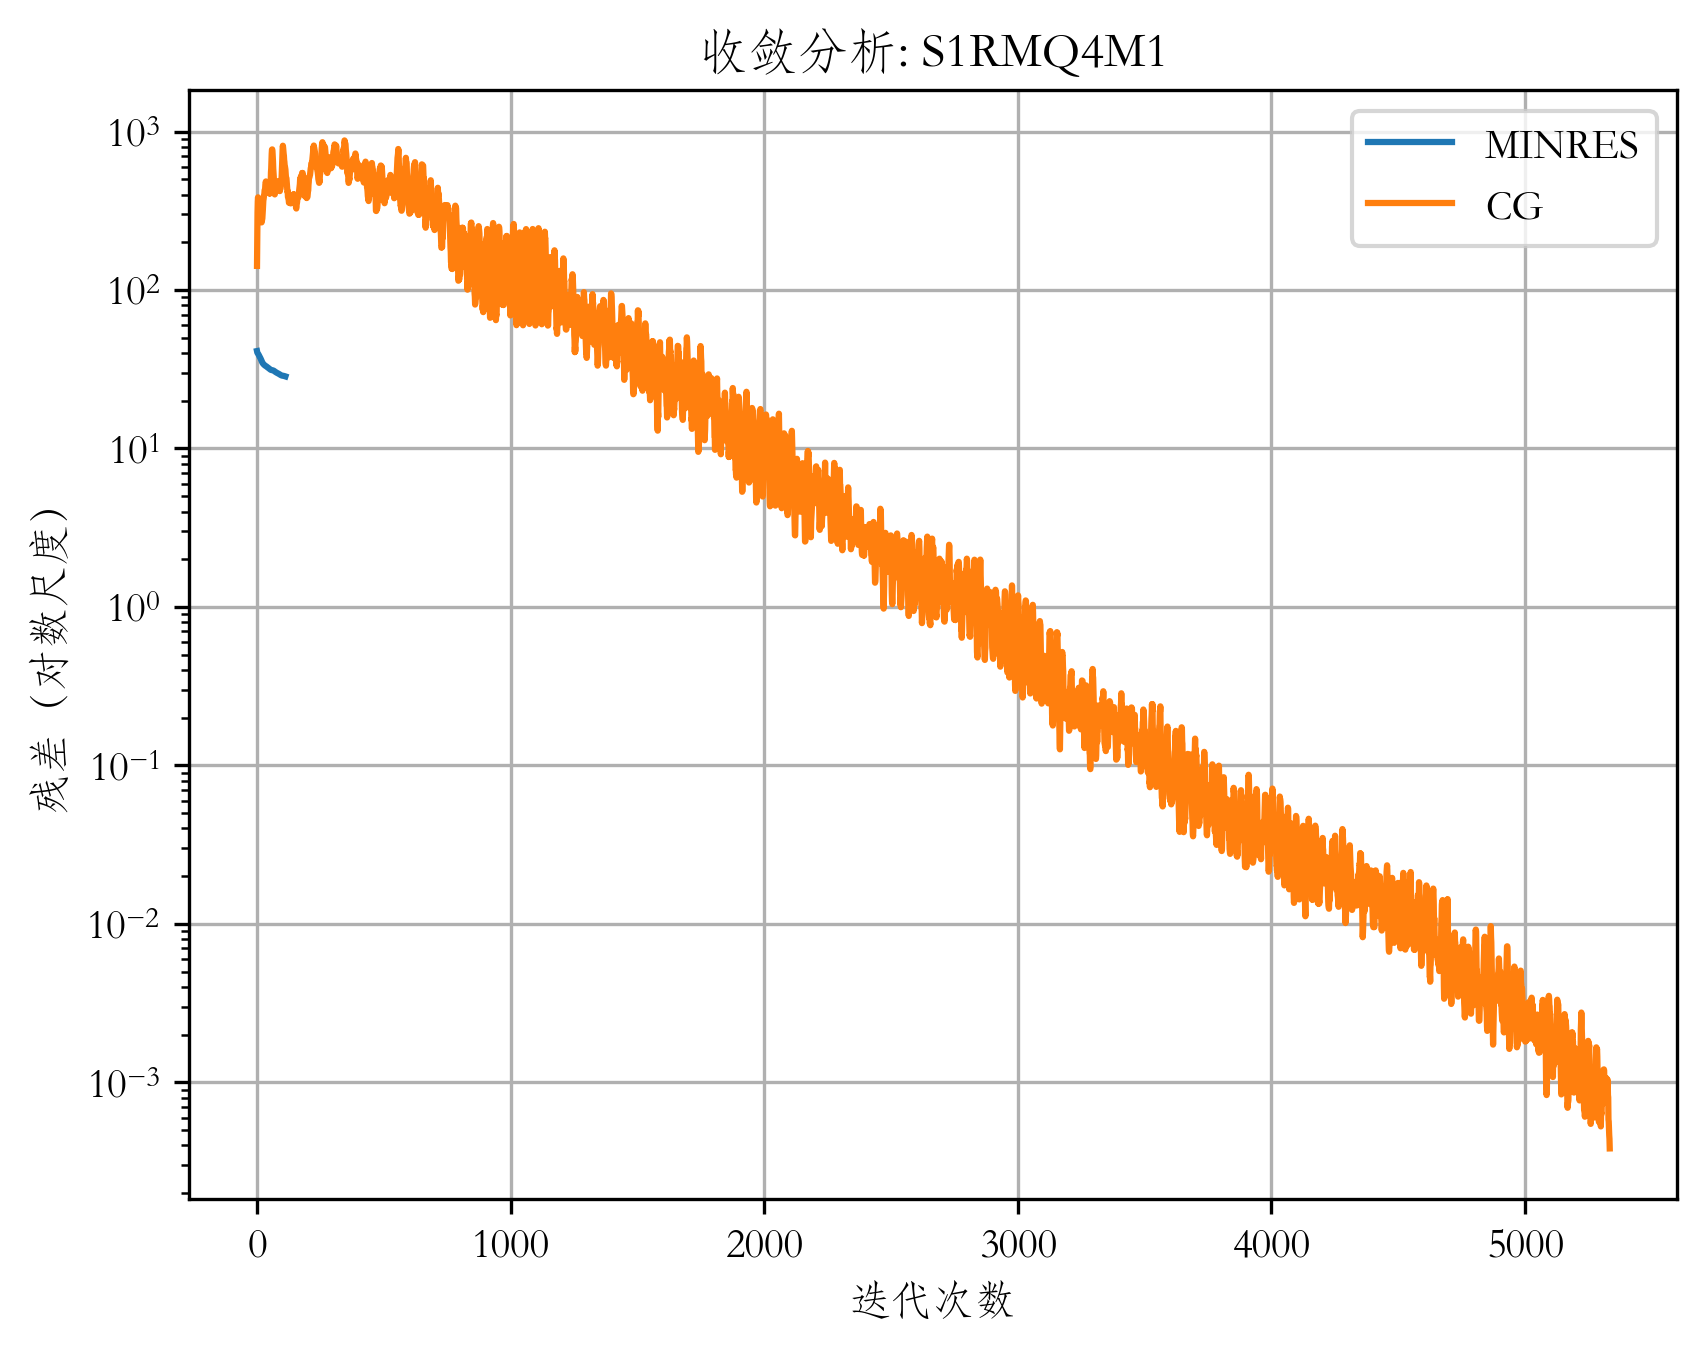

Matrix: S1RMQ4M1
MINRES Time: 0.064862 seconds
CG Time: 2.632543 seconds



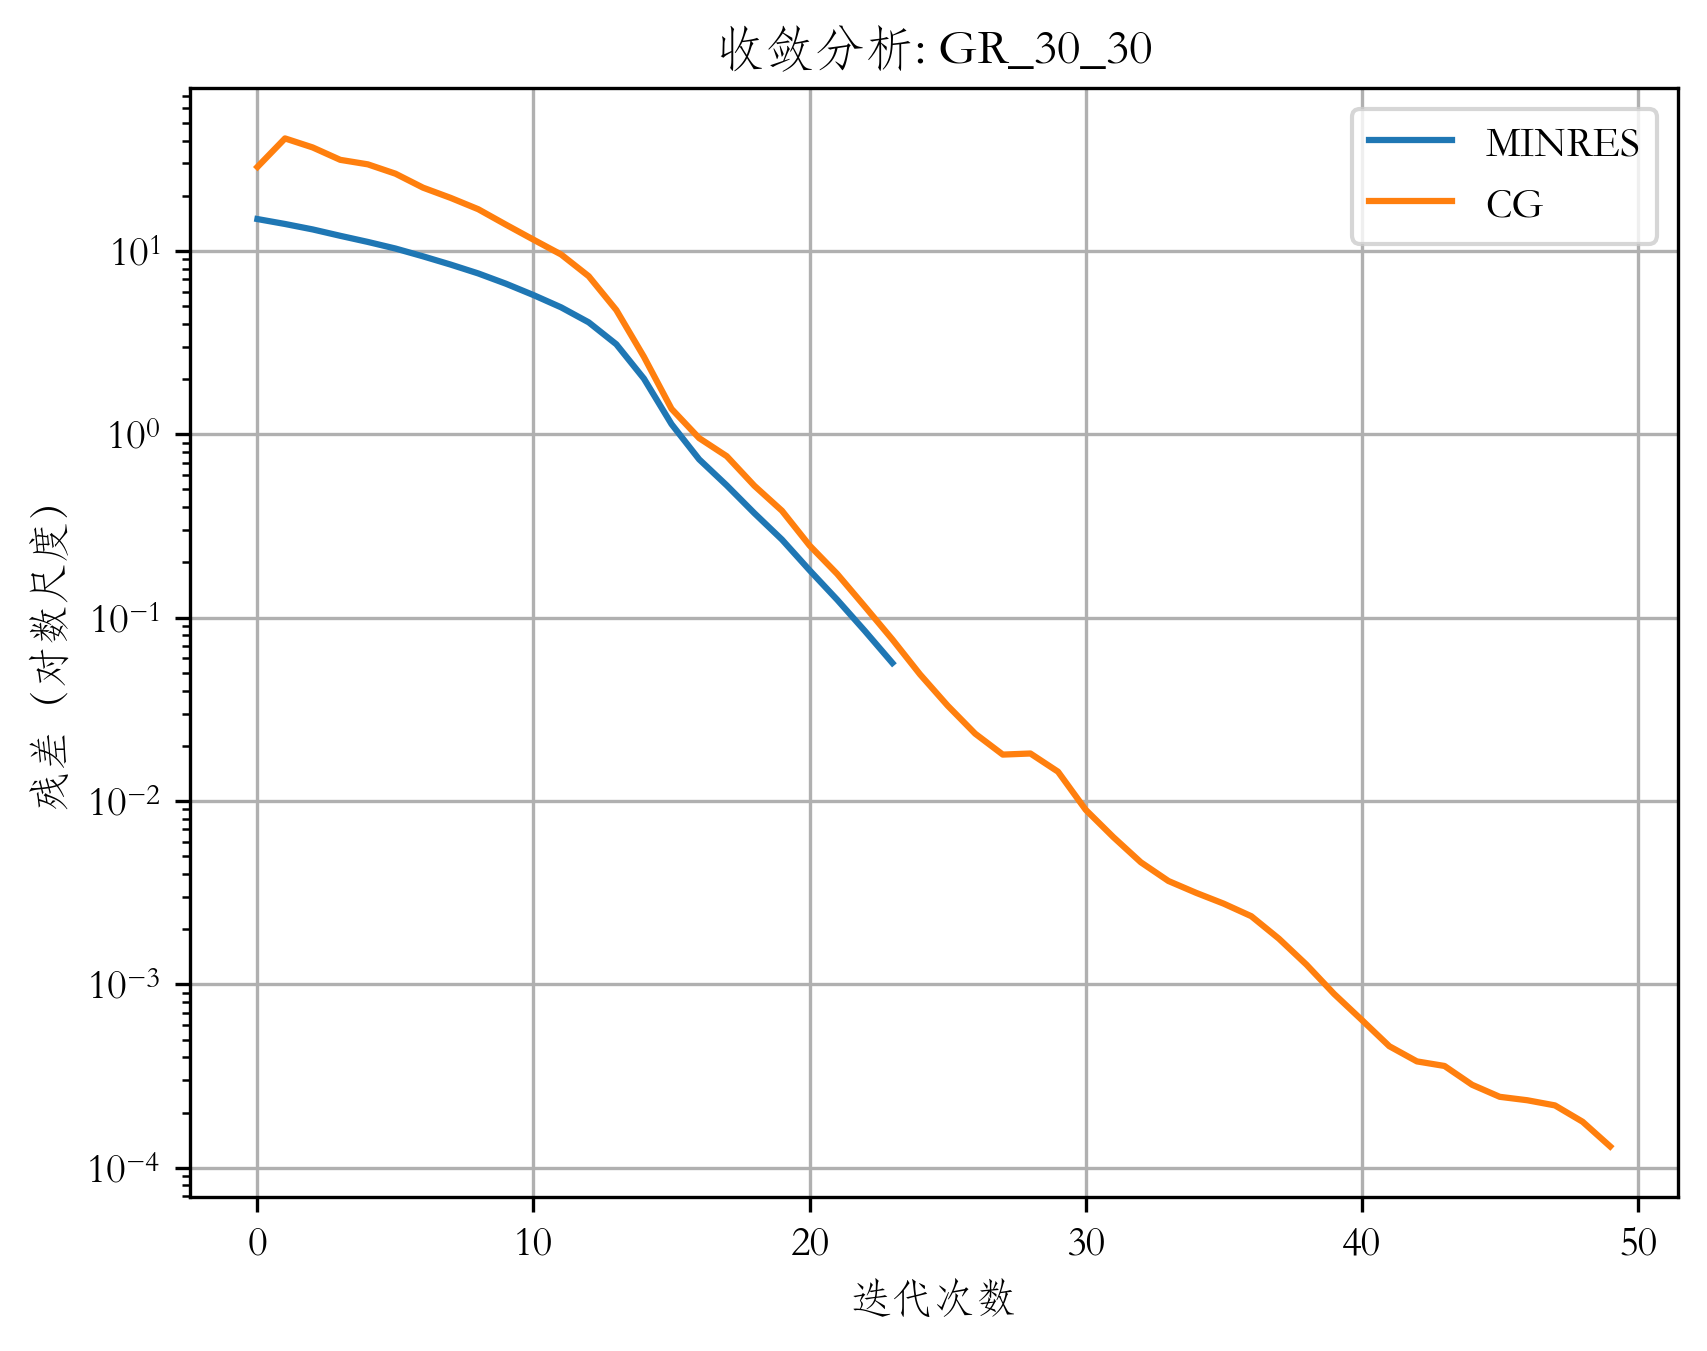

Matrix: GR_30_30
MINRES Time: 0.003128 seconds
CG Time: 0.002552 seconds



In [10]:
import numpy as np
from scipy.io import mmread
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import time

def minres(A, b, tol=1e-8, maxiter=1000, callback=None):
    n = len(b)
    x = np.zeros(n)
    r = b - A @ x
    residuals = [np.linalg.norm(r)]

    if callback is not None:
        callback(x)

    if residuals[-1] < tol:
        return x, 0

    # Initialize variables
    v_prev = np.zeros(n)
    v = r / residuals[-1]
    beta = residuals[-1]
    beta_prev = 0
    c = 1
    c_prev = 1
    s = 0
    s_prev = 0
    w_prev = np.zeros(n)
    w = v.copy()

    for k in range(maxiter):
        # Lanczos process
        Av = A @ v
        alpha = np.dot(v, Av)
        v_next = Av - alpha * v - beta * v_prev

        beta_next = np.linalg.norm(v_next)
        v_next /= beta_next

        # Givens rotation
        rho = np.sqrt(alpha**2 + beta_next**2)
        c_k = alpha / rho
        s_k = beta_next / rho

        # Update solution
        w_next = (v - beta_prev * s_prev * w_prev - beta * c_prev * w) / rho
        x += c_k * beta * w_next

        if callback is not None:
            callback(x)

        # Update residuals
        residual_norm = abs(s_k) * beta_next
        residuals.append(residual_norm)

        if residual_norm < tol:
            return x, 0

        # Update variables
        v_prev = v
        v = v_next
        beta_prev = beta
        beta = beta_next
        w_prev = w
        w = w_next
        c_prev = c
        c = c_k
        s_prev = s
        s = s_k

    return x, maxiter


def cg(A, b, tol=1e-8, maxiter=1000, callback=None):
    n = len(b)
    x = np.zeros(n)
    r = b - A @ x
    p = r.copy()
    residuals = [np.linalg.norm(r)]

    if callback is not None:
        callback(x)

    if residuals[-1] < tol:
        return x, 0

    for k in range(maxiter):
        Ap = A @ p
        alpha = np.dot(r, r) / np.dot(p, Ap)
        x += alpha * p
        r_new = r - alpha * Ap

        if callback is not None:
            callback(x)

        residual_norm = np.linalg.norm(r_new)
        residuals.append(residual_norm)

        if residual_norm < tol:
            return x, 0

        beta = np.dot(r_new, r_new) / np.dot(r, r)
        p = r_new + beta * p
        r = r_new

    return x, maxiter


def load_matrix(matrix_name):
    matrix = mmread(f'{matrix_name}.mtx')
    return csr_matrix(matrix)


def generate_random_vector(n):
    return np.random.rand(n)


def make_callback(A, b, residuals):
    def callback(xk):
        residual = np.linalg.norm(b - A @ xk)
        residuals.append(residual)
    return callback


def compare_algorithms(A, b):
    # MINRES
    residuals_minres = []
    callback_minres = make_callback(A, b, residuals_minres)
    start_time = time.time()
    x_minres, info_minres = minres(A, b, callback=callback_minres)
    minres_time = time.time() - start_time

    # CG
    residuals_cg = []
    callback_cg = make_callback(A, b, residuals_cg)
    start_time = time.time()
    x_cg, info_cg = cg(A, b, callback=callback_cg)
    cg_time = time.time() - start_time

    return residuals_minres, residuals_cg, minres_time, cg_time


matrices = ['BCSSTK15', 'S1RMQ4M1', 'GR_30_30']

for matrix_name in matrices:
    A = load_matrix(matrix_name)
    b = generate_random_vector(A.shape[0])
    
    residuals_minres, residuals_cg, minres_time, cg_time = compare_algorithms(A, b)
    
    # 绘制收敛曲线
    plt.figure()
    plt.semilogy(residuals_minres, label='MINRES')
    plt.semilogy(residuals_cg, label='CG')
    plt.xlabel('迭代次数')
    plt.ylabel('残差（对数尺度）')
    plt.title(f'收敛分析: {matrix_name}')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Matrix: {matrix_name}")
    print(f"MINRES Time: {minres_time:.6f} seconds")
    print(f"CG Time: {cg_time:.6f} seconds")
    print()